Metrics binary lens systems like planets
new format


# Extract fit and true values

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import os, sys
import re
from tqdm.auto import tqdm
from pyLIMA import telescopes
from pyLIMA.models import PSBL_model
from pyLIMA.models import USBL_model
from pyLIMA.models import FSPLarge_model
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA import event
from tqdm.auto import tqdm
from astropy.time import Time
from astropy import constants as const
from astropy import units as u
from tqdm.auto import tqdm
import h5py
from astropy.table import QTable

import math
home = '/home/anibal/'
sys.path.append(home + '/roman_rubin/fit_codes')
# this codes are in the /fit_codes directory 
# https://github.com/anibal-art/roman_rubin/tree/main/fit_codes
# from fit_results import chi_dof, best_model, event_fits, sigmas
# from fit_results import 
# from filter_curves import read_curves
# from analysis_metrics import m1,m2,m3, fit_true, metrics, sigma_ratio, bias_ratio, fit_values
# from plot_models import plot_LCmodel
# from plot_lightcurves import model
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# from plot_models import plot_only_model

import pandas as pd
import numpy as np
import math
import astropy.units as u
import astropy.constants as const
from tqdm.auto import tqdm


def event_fits(path_fits):
    '''
    return events in common with roman and rubin
    we have events that fits only one of two for unkown reasons
    '''
    
    files_fits = os.listdir(path_fits)
    
    files_roman = [f for f in files_fits if 'Roman' in f]
    files_rr = [f for f in files_fits if not 'Roman' in f]
    
    n_rom = [] # list with the event number
    for j in files_roman:
        number = int(re.findall(r'\d+', j)[0])
        n_rom.append(number)
    
    n_rr = [] # # list with the event number
    for j in files_rr:
        number = int(re.findall(r'\d+', j)[0])
        n_rr.append(number)
    
    # Convert lists to sets
    set1 = set(n_rom)
    set2 = set(n_rr)
    # Find the common elements using intersection
    common_elements = set1.intersection(set2)
    # Convert the result back to a list (if needed)
    common_elements_list = list(common_elements)
    return common_elements_list


In [3]:
path_ephemerides = '/home/anibal/files_db/james_webb.txt' #PATH TO EPHEMERIDES
path = '/home/anibal/results_roman_rubin/FFP_final/FFP/'
save_results = path+'results/'
path_model = ['set_sim'+str(i)+'/' for i in range(1,9)]
path_fit = ['set_fit'+str(i)+'/' for i in range(1,9)]
path_set_sim = [path+'set_sim'+str(i)+'/' for i in range(1,9)]
path_set_fit = [path+'set_fit'+str(i)+'/' for i in range(1,9)]

In [4]:
label = {'piEE':'\\pi_{EE}','piEN':'\\pi_{EN}','rho':'\\rho','t0':'t_0','te':'t_E','u0':'u_0','s':'s','q':'q','alpha':'\\alpha', 'piE':'\\pi_E'}
labels = {'t0':'t_0', 'u0':'u_0', 'te':'t_E','rho':'\\rho', 's':'s', 'q':'q', 'alpha':'\\alpha', 'piEE':'\pi_{EE}', 'piEN':'\pi_{EN}'}


In [5]:
filenames =[path+"set_fit2/"+f for f in os.listdir(path+"set_fit2") if "RR" in f]
nflux = []
pflux = []
for i in range(len(filenames)):
    try:
        fit_data = np.load(filenames[i],allow_pickle=True).item()
        fit_flux = fit_data["best_model"][9:len(fit_data["best_model"])]
        if any(np.array(fit_flux)<0):
            nflux.append(1)
        else:
            pflux.append(1)
    except: 
        pass
print(len(nflux))
print(len(pflux))


0
270


In [6]:
# np.load(path+'set_fit1/Event_Roman_126_TRF.npy',allow_pickle=True).item()['best_model']
# print(np.load(path+'set_fit1/Event_Roman_126_TRF.npy',allow_pickle=True).item()['best_model'][3:5])
# np.load(path+'set_fit1/Event_Roman_126_TRF.npy',allow_pickle=True).item()['covariance_matrix']

In [7]:

def new_rows(camino,st):
    data_rr = np.load(camino,allow_pickle=True).item()
    labels_params = ['t0','u0','te','rho','piEN','piEE']
    fit_values = dict(zip(labels_params, 
                          data_rr['best_model'][0:6]))

    if any(np.diag(data_rr['covariance_matrix'])<0):
        fit_error = np.zeros(6)
    else:
        fit_error= np.sqrt(np.diag(data_rr['covariance_matrix']))[0:6]

    for j,key in enumerate(labels_params):
        fit_values[key+'_err']=fit_error[j]
    fit_values['Source'] = data_rr['true_params'].name+st*5000

    true_values = data_rr['true_params'][['t0','u0','te','rho','piEN','piEE']].to_dict()#.values[0:9])
    true_values['Source']=data_rr['true_params'].name+st*5000

    new_row_true = pd.DataFrame([true_values])
    new_row_fit = pd.DataFrame([fit_values])
    return new_row_true, new_row_fit

def fit_true(path):
    cols_true = ['Source','t0','u0','te','rho','piEN','piEE']
    cols_fit=cols_true+[t+'_err' for t in ['t0','u0','te','rho','piEN','piEE']]

    true = pd.DataFrame(columns=cols_true)
    fit_rr = pd.DataFrame(columns=cols_fit)
    fit_roman = pd.DataFrame(columns=cols_fit)
    fit_completed = []
    for st in tqdm(range(1,5)):
        PATH = path+f'set_fit{st}/'
        # print(PATH)
        nevent = event_fits(PATH)
        # print(len(nevent))
        # print(len([f for f in os.listdir(path) if "RR" in f] ))
        # print(len([f for f in os.listdir(path) if "Roman" in f] ))
        list_files_rr = [f'Event_RR_{int(f)}_TRF.npy' for f in nevent]
        list_files_roman = [f'Event_Roman_{int(f)}_TRF.npy' for f in nevent]

        for i in range(len(nevent)):
            path_rr = PATH+list_files_rr[i]
            path_roman = PATH+list_files_roman[i]
            try:
            # if i==126:
                # print(path_rr)
                new_row_true, new_row_rr = new_rows(path_rr,st)
                new_row_true2, new_row_roman = new_rows(path_roman,st)
                # print(new_row_true)
                # print(any(new_row_true.values[0]==new_row_true2.values[0]))
                true = pd.concat([true, new_row_true], ignore_index=True)
                fit_rr = pd.concat([fit_rr, new_row_rr], ignore_index=True)
                fit_roman = pd.concat([fit_roman, new_row_roman], ignore_index=True)

                fit_completed.append(1)

            except:
                # print(i)
                fit_completed.append(0)
    return true, fit_rr, fit_roman

true, fit_rr, fit_roman = fit_true(path)

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_5632/1016858227.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  true = pd.concat([true, new_row_true], ignore_index=True)
/tmp/ipykernel_5632/1016858227.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fit_rr = pd.concat([fit_rr, new_row_rr], ignore_index=True)
/tmp/ipykernel_5632/1016858227.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when

In [8]:
fit_rr

,Source,t0,u0,te,rho,piEN,piEE,t0_err,u0_err,te_err,rho_err,piEN_err,piEE_err
0,9097,2.461838e+06,0.885704,0.834813,7.676219e-02,0.000482,-0.000073,0.132301,0.250064,0.016363,0.095546,84.198768,4.442201
1,9107,2.462574e+06,0.553660,4.901452,6.428153e-27,0.001041,0.000018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5011,2.462767e+06,0.267914,1.768158,1.074620e-02,0.000152,0.000143,0.064016,1.887665,0.051358,0.238725,332.621957,4.955878
3,9116,2.462896e+06,0.144701,15.592381,2.800095e-02,0.000037,-0.000698,0.864610,0.059797,0.475956,0.031861,0.899675,0.069459
4,5023,2.462608e+06,0.466860,0.635704,1.658945e-02,0.001269,0.000265,0.042343,1.389264,0.018716,0.554270,157.605320,7.568450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,21925,2.462970e+06,0.778273,4.422761,2.002950e-01,0.000097,-0.000380,0.049172,0.086274,0.088617,0.020340,9.493048,0.610061
808,24002,2.461706e+06,-0.028354,1.286313,9.200923e-01,0.000148,-0.000164,0.001316,0.906925,0.012563,0.001531,72.581738,5.757476
809,21992,2.461828e+06,0.905728,0.962218,9.752390e-01,0.000430,-0.000326,0.002270,0.008130,0.003337,0.005480,1.424305,2.250784
810,22030,2.461841e+06,0.316761,1.549785,3.574116e-01,0.000057,0.001161,0.020747,0.019477,0.002069,0.005370,7.401264,0.238143


In [9]:
# try:
#     fit_rr = pd.read_csv(save_results+'fit_rr_ffp.csv')
#     fit_roman = pd.read_csv(save_results+'fit_roman_ffp.csv')
#     true = pd.read_csv(save_results+'true_ffp.csv')
# except:
#     fit_rr, fit_roman, true = fit_true(path)
#     fit_rr.to_csv(save_results+'fit_rr_ffp.csv', index=False)
#     fit_roman.to_csv(save_results+'fit_roman_ffp.csv', index=False)
#     true.to_csv(save_results+'true_ffp.csv', index=False)

In [10]:

def read_data(path_model):
    # Open the HDF5 file and load data using specified names
    with h5py.File(path_model, 'r') as file:
        # Load array with string with info of dataset using its name
        info_dataset = file['Data'][:]
        info_dataset = [file['Data'][:][0].decode('UTF-8'), file['Data'][:][1].decode('UTF-8'),
                        [file['Data'][:][2].decode('UTF-8'), [0, 0]]]
        # Dictionary using its name
        pyLIMA_parameters = {key: file['pyLIMA_parameters'].attrs[key] for key in file['pyLIMA_parameters'].attrs}
        # Load table using its name
        bands = {}
        for band in ("W149", "u", "g", "r", "i", "z", "y"):
            loaded_table = QTable()
            for col in file[band]:
                loaded_table[col] = file[band][col][:]
            bands[band] = loaded_table
        return info_dataset, pyLIMA_parameters, bands


def chichi(name_file):
    '''
    name_file(str):This function receives as input the name of the file
    example: /home/user/model/set_sim1/Event_RR_42_trf.npy.
    '''
    # print(name_file[name_file.index('Event_')-2])
    nset = int(name_file[name_file.index('Event_')-2:name_file.index('Event_')-1])

    # print(nset)
    name_set = 'set_sim'+str(nset)
    directory_simset = name_file[0:name_file.index('set')]+name_set+'/'
    # print()
    nevent = re.sub(r'\D', '', name_file[name_file.index('Event_'):-1])
    
    model_file = directory_simset+'Event_'+str(nevent)+'.h5'
    info_dataset, model_params, curves=read_data(name_file)
    # curves,model_params = read_curves(model_file)
    name_file_rr=name_file[0:name_file.index('set')]+f"/set_fit{nset}/Event_RR_{nevent}_TRF.npy"
    name_file_roman=name_file[0:name_file.index('set')]+f"/set_fit{nset}/Event_Roman_{nevent}_TRF.npy"
    data_rr = np.load(name_file_rr,allow_pickle=True)
    data_roman = np.load(name_file_roman,allow_pickle=True)
    # print(data_rr)
    try:
        chi_rr =data_rr.item()["chi2"] 
        chi_roman =data_roman.item()["chi2"]

        dof_rr = sum([len(curves[key]) for key in curves])-len([len(curves[key]) for key in curves if not len(curves[key])==0])*2-9
        dof_roman =len(curves['W149'])-2-9
        # print(model_params)
        # print(chi_roman/dof)
        return chi_rr/dof_rr, chi_roman/dof_roman
    except:
        return 0,0

# name_file = path+'set_sim1/Event_298.h5'
# info_dataset, pyLIMA_parameters, bands=read_data(name_file)
# print(bands.keys())
# chichi(name_file)

In [11]:
from tqdm.auto import tqdm

# try:
    # fit_rr["chi2"]
# except:
    # name_file = [f for f in os.listdir(path+"set_sim1/")]
    # print(path+"set_fit1/"+name_file[0])
    # print(chichi(path+"set_sim1/"+name_file[2]))

id_to_chi2_rr = {}
id_to_chi2_roman = {}

for i in tqdm(range(1,9)):
    common_elements_list = event_fits(path+f"set_fit{i}/")
    if not len(common_elements_list)==0:
        for j in range(len(common_elements_list)):
            name_file = f"Event_{common_elements_list[j]}.h5"
            chi2rr, chi2roman = chichi(path+f"set_sim{i}/"+name_file)
            # print(chi2rr, chi2roman)
            id_to_chi2_rr[int(common_elements_list[j]+i*5000)] =chi2rr
            id_to_chi2_roman[int(common_elements_list[j]+i*5000)] =chi2roman

fit_rr['chi2'] = fit_rr['Source'].map(id_to_chi2_rr)
fit_roman['chi2'] = fit_roman['Source'].map(id_to_chi2_roman)
# fit_rr.to_csv(save_results+'fit_rr_ffp.csv', index=False)
# fit_roman.to_csv(save_results+'fit_roman_ffp.csv', index=False)
# true.to_csv(save_results+'true_ffp.csv', index=False)

  0%|          | 0/8 [00:00<?, ?it/s]

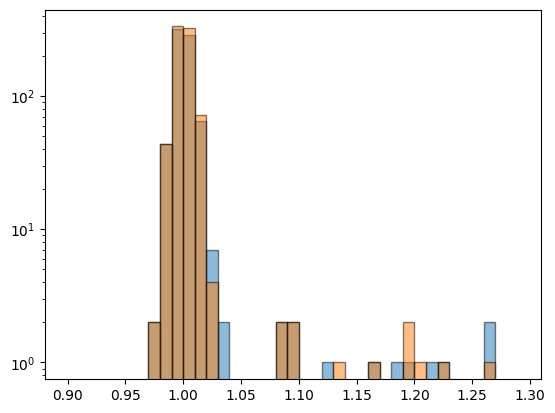

In [12]:
plt.hist(fit_rr['chi2'].values, bins=np.arange(0.9,1.3,0.01),alpha=0.5,edgecolor='k')
plt.hist(fit_roman['chi2'].values, bins=np.arange(0.9,1.3,0.01),alpha=0.5,edgecolor='k')
plt.yscale('log')

In [13]:
# !pip install seaborn

In [14]:

import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings

cov_piEE_piEN={}
# cov_rho_piEE={}
# cov_rho_piEN={}
cov_piEE_piEN_rom={}
# cov_rho_piEE_rom={}
# cov_rho_piEN_rom={}

for i in tqdm(range(len(fit_rr))):
    nsource = fit_rr["Source"].iloc[i]
    nset = int(nsource/5000)
    nevent = nsource-nset*5000
    
    data = np.load(path+f"set_fit{nset}/Event_RR_{nevent}_TRF.npy",allow_pickle=True)
    data_rom = np.load(path+f"set_fit{nset}/Event_Roman_{nevent}_TRF.npy",allow_pickle=True)
    
    best_model = data.item()['best_model']
    covariance_matrix = data.item()['covariance_matrix']
    cov_piEE_piEN[nsource]=covariance_matrix[4,5]
    # cov_rho_piEE[nsource]=covariance_matrix[3,7]
    # cov_rho_piEN[nsource]=covariance_matrix[3,8]
    
    best_model_rom = data_rom.item()['best_model']
    covariance_matrix_rom = data_rom.item()['covariance_matrix']
    # print(covariance_matrix_rom)
    # print(covariance_matrix_rom[4,5])
    cov_piEE_piEN_rom[nsource]=covariance_matrix_rom[4,5]
    # cov_rho_piEE_rom[nsource]=covariance_matrix_rom[3,7]
    # cov_rho_piEN_rom[nsource]=covariance_matrix_rom[3,8]
    
fit_rr["cov_piEE_piEN"]= fit_rr['Source'].map(cov_piEE_piEN)
# fit_rr["cov_rho_piEE"] = fit_rr['Source'].map(cov_rho_piEE)
# fit_rr["cov_rho_piEN"] = fit_rr['Source'].map(cov_rho_piEN)
fit_roman["cov_piEE_piEN"]= fit_rr['Source'].map(cov_piEE_piEN_rom)
# fit_roman["cov_rho_piEE"] = fit_rr['Source'].map(cov_rho_piEE_rom)
# fit_roman["cov_rho_piEN"] = fit_rr['Source'].map(cov_rho_piEN_rom)

  0%|          | 0/812 [00:00<?, ?it/s]

In [15]:
for i in range(1,2):
    lista_sim1 = [int(''.join(re.findall(r'\d+', f))) for f in os.listdir(path+f'set_sim{i}') if 'txt' in f]
print(len(lista_sim1))

for i in range(1,2):
    lista_fit1 = [int(''.join(re.findall(r'\d+', f))) for f in os.listdir(path+f'set_fit{i}') if 'npy' in f]
print(len(lista_fit1))


set1 = set(lista_sim1)
set2 = set(lista_fit1)

# Find numbers that are unique to each list
unique_to_list1 = set1 - set2
unique_to_list2 = set2 - set1


0
1588


0 0 t0
0 1 u0
0 2 te
1 0 rho
1 1 piEN
1 2 piEE


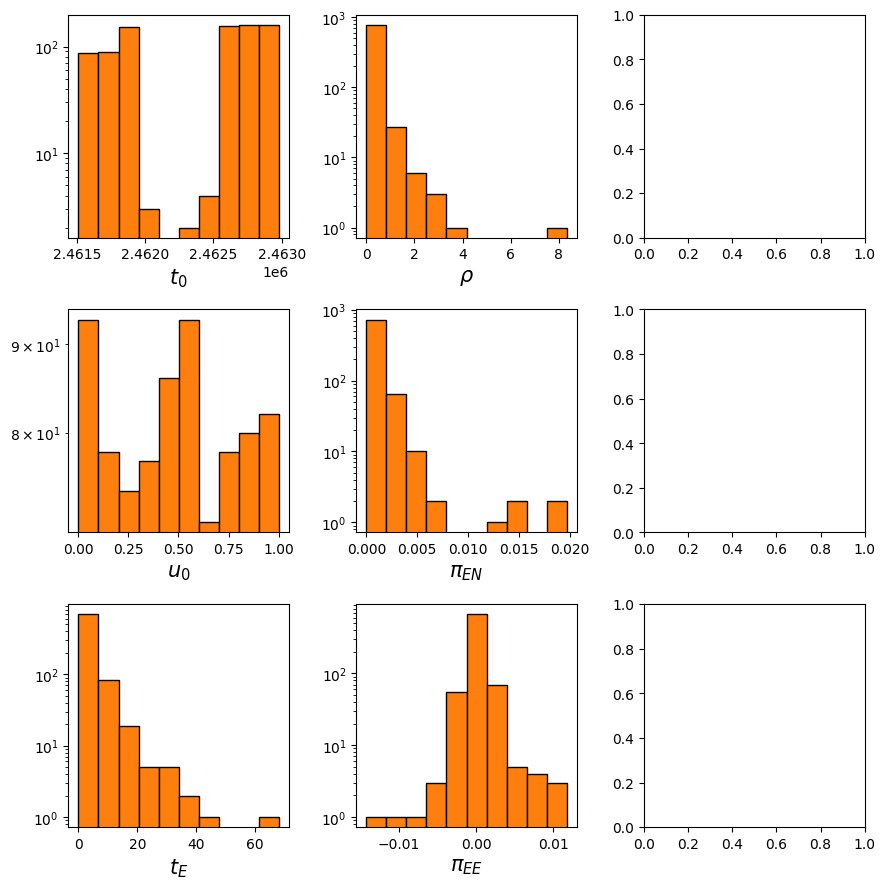

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(9,9))
for i,p in enumerate(['t0', 'u0', 'te','rho', 'piEN', 'piEE']):
    row, col = divmod(i, 3)
    
    print(row,col,p)
    axs[col,row].hist(true[p])
    axs[col,row].hist(true[p],edgecolor='black')
    axs[col,row].set_xlabel(f'${label[p]}$',fontsize=15)
    axs[col,row].set_yscale('log')
    # axs[col,row].set_xscale('log')
    if p == 'piE':
        axs[col,row].hist(np.sqrt(true['piEE']**2 + true['piEN']**2),edgecolor='black')
        axs[col,row].set_xlabel(f'${label[p]}$',fontsize=15)
        axs[col,row].set_yscale('log')

plt.tight_layout()
plt.show()

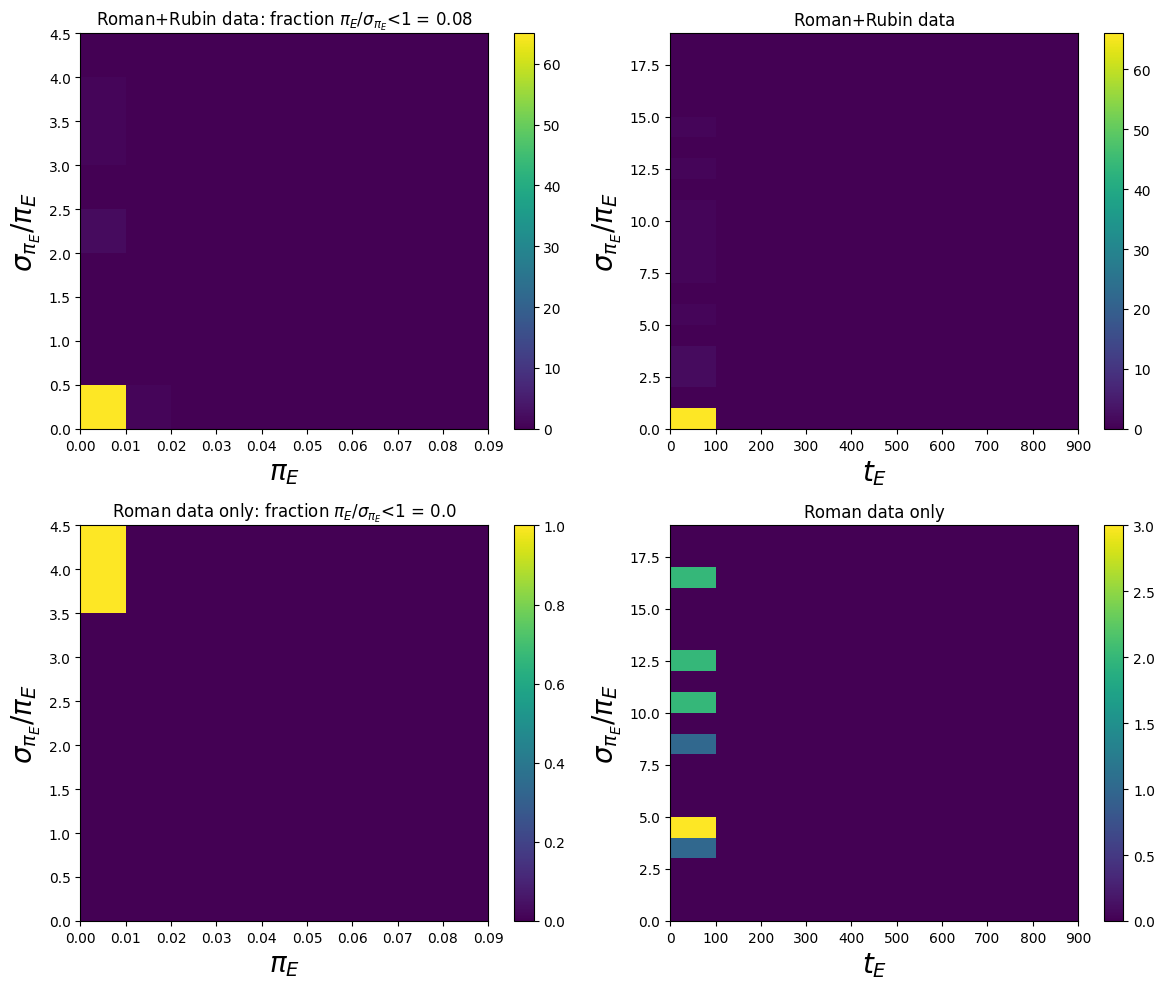

In [17]:
# Create a figure and a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot for Roman+Rubin data - subplot (0, 0)

piE_rr = np.sqrt(fit_rr['piEN']**2 + fit_rr['piEE']**2)
sigma_piE_rr = (1/piE_rr) * np.sqrt((fit_rr['piEN']*fit_rr['piEN_err'])**2 )#+ (fit_rr['piEE']*fit_rr['piEE_err'])**2)
f_rr = [f for f in sigma_piE_rr/piE_rr if f<0.1]
fraction_roman = len(f_rr)/len(sigma_piE_rr/piE_rr)
axs[0, 0].set_title('Roman+Rubin data: fraction $\pi_{E}/\sigma_{\pi_{E}}$<1 = '+str(round(fraction_roman,3)))
h = axs[0, 0].hist2d(piE_rr, sigma_piE_rr/piE_rr, bins=(np.arange(0, 0.1, 0.01), np.arange(0, 5, 0.5)))
axs[0, 0].set_xlabel(r'$\pi_{E}$', fontsize=20)
axs[0, 0].set_ylabel(r'$\sigma_{\pi_{E}}/\pi_{E}$', fontsize=20)
plt.colorbar(h[3], ax=axs[0,0])  # Add color bar to the subplot


# Plot for Roman+Rubin data - subplot (0, 1)
axs[0, 1].set_title('Roman+Rubin data')
# piE_rr = np.sqrt(fit_rr['piEN']**2 + fit_rr['piEE']**2)
sigma_piE_rr = (1/piE_rr) * np.sqrt((fit_rr['piEN']*fit_rr['piEN_err'])**2 )#+ (fit_rr['piEE']*fit_rr['piEE_err'])**2)
h=axs[0, 1].hist2d(fit_rr['te'], sigma_piE_rr/piE_rr, bins=(np.arange(0, 1000, 100), np.arange(0, 20, 1)))
axs[0, 1].set_ylabel(r'$\sigma_{\pi_{E}}/\pi_{E}$', fontsize=20)
axs[0, 1].set_xlabel(r'$t_{E}$', fontsize=20)
plt.colorbar(h[3], ax=axs[0,1])  # Add color bar to the subplot
# Plot for Roman data only - subplot (1, 0)

piE_roman = np.sqrt(fit_roman['piEN']**2 + fit_roman['piEE']**2)
sigma_piE_roman = (1/piE_roman) * np.sqrt((fit_roman['piEN']*fit_roman['piEN_err'])**2 + (fit_roman['piEE']*fit_roman['piEE_err'])**2)
sigma_piE_roman = (1/piE_roman) * np.sqrt((fit_roman['piEN']*fit_roman['piEN_err'])**2 + (fit_roman['piEE']*fit_roman['piEE_err'])**2)
f_roman = [f for f in sigma_piE_roman/piE_roman if f<0.1]
fraction_roman = len(f_roman)/len(sigma_piE_roman/piE_roman)
axs[1, 0].set_title('Roman data only: fraction $\pi_{E}/\sigma_{\pi_{E}}$<1 = '+str(round(fraction_roman,3)))
h=axs[1, 0].hist2d(piE_roman, sigma_piE_roman/piE_roman, bins=(np.arange(0, 0.1, 0.01), np.arange(0, 5, 0.5)))
axs[1, 0].set_xlabel(r'$\pi_{E}$', fontsize=20)
axs[1, 0].set_ylabel(r'$\sigma_{\pi_{E}}/\pi_{E}$', fontsize=20)
plt.colorbar(h[3], ax=axs[1,0])  # Add color bar to the subplot
# Plot for Roman data only - subplot (1, 1)

# piE_roman = np.sqrt(fit_roman['piEN']**2 + fit_roman['piEE']**2)
axs[1, 1].set_title('Roman data only')
h=axs[1, 1].hist2d(fit_roman['te'], sigma_piE_roman/piE_roman, bins=(np.arange(0, 1000, 100), np.arange(0, 20, 1)))
axs[1, 1].set_ylabel(r'$\sigma_{\pi_{E}}/\pi_{E}$', fontsize=20)
axs[1, 1].set_xlabel(r'$t_{E}$', fontsize=20)
plt.colorbar(h[3], ax=axs[1,1])  # Add color bar to the subplot
# axs[1, 1].set_colorbar()
# Adjust layout to prevent clipping of titles
plt.tight_layout()
# Show the plot
plt.show()


# Veamos las metricas

In [18]:
# save_results = '/home/anibal/results_roman_rubin/FFP_v5/FFP/results/'
met_1_rr = pd.DataFrame(columns = true.columns)
met_1_roman= pd.DataFrame(columns = true.columns)
met_2_rr = pd.DataFrame(columns = true.columns)
met_2_roman= pd.DataFrame(columns = true.columns)
met_3_rr = pd.DataFrame(columns = true.columns)
met_3_roman= pd.DataFrame(columns = true.columns)
err_ratio= pd.DataFrame(columns = true.columns)
residuals_ratio= pd.DataFrame(columns = true.columns)
err_ratio['Source']=true['Source']
residuals_ratio['Source']=true['Source']

met_1_roman['Source']=true['Source']
met_1_rr['Source']=true['Source']
met_2_roman['Source']=true['Source']
met_2_rr['Source']=true['Source']
met_3_roman['Source']=true['Source']
met_3_rr['Source']=true['Source']
keys = ['t0',
'u0',
'te',
'rho',
'piEN',
'piEE']
for key in keys:
    met_1_rr[key] = abs(true[key]-fit_rr[key])/true[key]
    met_1_roman[key] = abs(true[key]-fit_roman[key])/true[key]
    met_2_rr[key] = abs(true[key]-fit_rr[key])/fit_rr[key+'_err']
    met_2_roman[key] = abs(true[key]-fit_roman[key])/fit_roman[key+'_err']
    met_3_rr[key] = abs(fit_rr[key+'_err']/fit_rr[key])
    met_3_roman[key] = abs(fit_roman[key+'_err']/fit_roman[key])
    err_ratio[key]=abs(fit_rr[key+'_err'])/fit_roman[key+'_err']
    residuals_ratio[key]=abs(fit_rr[key+'_err'])/fit_roman[key+'_err']

In [19]:
true

,Source,t0,u0,te,rho,piEN,piEE
0,9097,2.461838e+06,0.895992,0.829565,0.137413,0.000350,-0.000140
1,9107,2.462574e+06,0.554348,4.900426,0.046087,0.000694,0.000037
2,5011,2.462767e+06,0.266106,1.774671,0.007164,0.000302,0.000096
3,9116,2.462896e+06,0.146072,15.753881,0.039224,0.000052,-0.001043
4,5023,2.462608e+06,0.466839,0.636432,0.011060,0.000847,0.000531
...,...,...,...,...,...,...,...
807,21925,2.462970e+06,0.785681,4.428924,0.306567,0.000193,-0.000253
808,24002,2.461706e+06,0.259583,1.045518,0.626987,0.000162,-0.000113
809,21992,2.461828e+06,0.863164,0.834195,0.650159,0.000287,-0.000652
810,22030,2.461841e+06,0.314919,1.550028,0.352968,0.000069,0.000957


In [20]:
fit_rr[fit_rr['Source']==9107]

,Source,t0,u0,te,rho,piEN,piEE,t0_err,u0_err,te_err,rho_err,piEN_err,piEE_err,chi2,cov_piEE_piEN
1,9107,2.462574e+06,0.55366,4.901452,6.428153e-27,0.001041,0.000018,0.0,0.0,0.0,0.0,0.0,0.0,0.990292,0.172243


In [21]:
met_3_rr[met_3_rr['piEE']<1]

,Source,t0,u0,te,rho,piEN,piEE
1,9107,0.0,0.0,0.0,0.0,0.0,0.0
8,9121,0.0,0.0,0.0,0.0,0.0,0.0
82,5628,0.0,0.0,0.0,0.0,0.0,0.0
171,8506,0.0,0.0,0.0,0.0,0.0,0.0
175,6474,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
729,20281,0.0,0.0,0.0,0.0,0.0,0.0
730,22336,0.0,0.0,0.0,0.0,0.0,0.0
772,20917,0.0,0.0,0.0,0.0,0.0,0.0
779,21152,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
met_3_rr[met_3_rr['piEN']<1]

,Source,t0,u0,te,rho,piEN,piEE
1,9107,0.0,0.0,0.0,0.0,0.0,0.0
8,9121,0.0,0.0,0.0,0.0,0.0,0.0
82,5628,0.0,0.0,0.0,0.0,0.0,0.0
171,8506,0.0,0.0,0.0,0.0,0.0,0.0
175,6474,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
729,20281,0.0,0.0,0.0,0.0,0.0,0.0
730,22336,0.0,0.0,0.0,0.0,0.0,0.0
772,20917,0.0,0.0,0.0,0.0,0.0,0.0
779,21152,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
print(len(met_3_rr[met_3_rr['piEE']>1])/len(met_3_rr))
print(len(met_3_rr[met_3_rr['piEN']>1])/len(met_3_rr))

0.9187192118226601
0.9224137931034483


(array([805.,   0.,   2.,   2.,   1.,   0.,   0.,   1.,   0.,   1.]),
 array([0.00000000e+00, 5.30986270e+07, 1.06197254e+08, 1.59295881e+08,
        2.12394508e+08, 2.65493135e+08, 3.18591762e+08, 3.71690389e+08,
        4.24789016e+08, 4.77887643e+08, 5.30986270e+08]),
 <BarContainer object of 10 artists>)

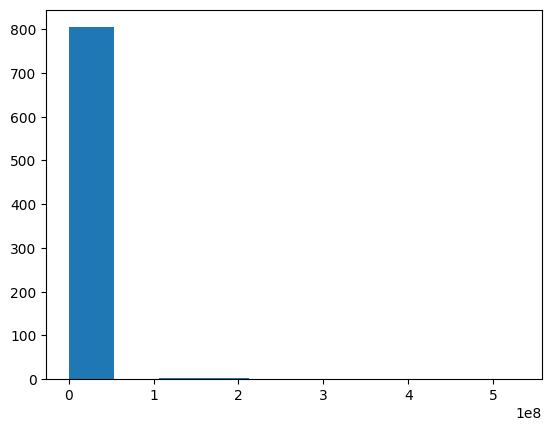

In [24]:
plt.hist(met_3_rr['piEE'])

## Distribuciones de las metricas


In [25]:
def group_consecutive_numbers(numbers):
    '''
    Defino comienzo y finalizacion de temporadas de observacion de Rubin en el campo de Roman
    '''
    numbers.sort()
    groups = []
    current_group = [numbers[0]]

    for i in range(1, len(numbers)):
        if numbers[i] - current_group[-1] < 60:
            current_group.append(numbers[i])
        else:
            groups.append(current_group)
            current_group = [numbers[i]]

    if current_group:
        groups.append(current_group)

    return groups



In [26]:
from astropy import units
%matplotlib inline

path_dataslice = '/home/anibal/roman_rubin/simulation/dataSlice_baseline.npy'
dataSlice = np.load(path_dataslice, allow_pickle=True)
nominal_seasons = [
    {'start': '2027-02-11T00:00:00', 'end': '2027-04-24T00:00:00'},
    {'start': '2027-08-16T00:00:00', 'end': '2027-10-27T00:00:00'},
    {'start': '2028-02-11T00:00:00', 'end': '2028-04-24T00:00:00'},
    {'start': '2030-02-11T00:00:00', 'end': '2030-04-24T00:00:00'},
    {'start': '2030-08-16T00:00:00', 'end': '2030-10-27T00:00:00'},
    {'start': '2031-02-11T00:00:00', 'end': '2031-04-24T00:00:00'},
]

dataSlice['observationStartMJD']
consecutive_numbers = dataSlice['observationStartMJD']
result = group_consecutive_numbers(consecutive_numbers)
rubin_seasons = []
roman_seasons = []
for group in result:
    rubin_seasons.append((min(group)+2400000.5,max(group)+2400000.5))
for season in nominal_seasons:
    roman_seasons.append((Time(season['start'], format='isot').jd,Time(season['end'], format='isot').jd))


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


In [27]:
def intervals_overlap(interval1, interval2):
    start1, end1 = interval1
    start2, end2 = interval2
    return (start1 <= end2 and end1 >= start2) or (start2 <= end1 and end2 >= start1)

categories = []
for i in range(len(true)):
    interval1 = (true['t0'].values[i]-true['te'].values[i], true['t0'].values[i]+true['te'].values[i])

    overlap_rubin=False
    for j in range(len(rubin_seasons)):
        interval2 = rubin_seasons[j]
        if intervals_overlap(interval1, rubin_seasons[j]):
            overlap_rubin=True
            break

    overlap_roman = False
    for k in range(len(roman_seasons)):
        interval2 = roman_seasons[k]
        if intervals_overlap(interval1, roman_seasons[k]):
            overlap_roman = True
            break
    
    if (overlap_rubin==True) and (overlap_roman==True):
        categories.append('A')
    if (overlap_rubin==True) and (not overlap_roman==True):
        categories.append('B')
    if (not overlap_rubin==True) and (not overlap_roman==True):
        categories.append('C')
    if (not overlap_rubin==True) and (overlap_roman==True):
        categories.append('D')

true['categories'] = categories

In [28]:
print(set(true['categories']))
print(len(true[true['categories']=='A']))
print(len(true[true['categories']=='B']))
print(len(true[true['categories']=='C']))
print(len(true[true['categories']=='D']))

{'B', 'D', 'A'}
585
21
0
206


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


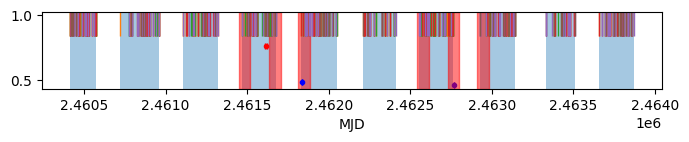

In [29]:
#set(true['categories'])
plt.figure(figsize=(8,1))
for group in result:
    plt.axvspan(min(group)+2400000.5,max(group)+2400000.5,alpha=0.4)

for fil in 'ugrizy':
    plt.plot(dataSlice['observationStartMJD'][dataSlice['filter']==fil]+2400000.5, np.ones(len(dataSlice['observationStartMJD'][dataSlice['filter']==fil])),'|',markersize=30)

for season in nominal_seasons:
    plt.axvspan(Time(season['start'], format='isot').jd,Time(season['end'], format='isot').jd,alpha=0.5,color='red')

plt.xlabel('MJD')

cats="ABD"
color_cat={'A':'b','B':'r','C':'k','D':'purple'}
for cat in cats:
    for i in range(0,1):
        # if true['te'].values[i]<60:
        # interval = (true['t0'][true["categories"]==cat].values[i]-true['te'][true["categories"]==cat].values[i]-2400000.5, true['t0'][true["categories"]==cat].values[i]+true['te'][true["categories"]==cat].values[i]-2400000.5)
        plt.errorbar(true[true["categories"]==cat]['t0'].values[i],np.random.uniform(0,1),yerr=None,xerr=true[true["categories"]==cat]['te'].values[i],color=color_cat[cat],marker='.',alpha=1,capsize=2)


For the propagation of $\pi_E$ I have to take into account the term outside the diagonal in the covariance matrix
$$\sigma_{\pi_E}^2 = 2Cov(\pi_{EE},\pi_{EN})\frac{\partial \pi_E}{\partial \pi_{EE}}\frac{\partial \pi_E}{\partial \pi_{EN}}+\left(\frac{\partial \pi_E}{\partial \pi_{EE}}\sigma_{\pi_{EE}}\right)^2+\left(\frac{\partial \pi_E}{\partial \pi_{EN}}\sigma_{\pi_{EN}}\right)^2$$

In [30]:
fit_rr['piE']=np.sqrt(fit_rr['piEN']**2+fit_rr['piEE']**2)
# fit_rr['piE_err'] = np.sqrt((fit_rr['piEN_err']**2-fit_rr['piEE_err']**2)/2+np.sqrt((fit_rr['piEN_err']**2-fit_rr['piEE_err']**2)**2+4*fit_rr['cov_piEE_piEN']**2)/2)

fit_rr['piE_err'] = (1/fit_rr['piE'])*np.sqrt((fit_rr['piEN_err']*fit_rr['piEN'])**2+(fit_rr['piEE_err']*fit_rr['piEE'])**2)#+2*fit_rr['piEE']*fit_rr['piEN']*fit_rr['cov_piEE_piEN'])

fit_roman['piE']=np.sqrt(fit_roman['piEN']**2+fit_roman['piEE']**2)
fit_roman['piE_err'] = (1/fit_roman['piE'])*np.sqrt((fit_roman['piEN_err']*fit_roman['piEN'])**2+(fit_roman['piEE_err']*fit_roman['piEE'])**2)#+2*fit_roman['piEE']*fit_roman['piEN']*fit_roman['cov_piEE_piEN'])
# fit_roman['piE_err'] = np.sqrt((fit_roman['piEN_err']**2-fit_roman['piEE_err']**2)/2+np.sqrt((fit_roman['piEN_err']**2-fit_roman['piEE_err']**2)**2+4*fit_roman['cov_piEE_piEN']**2)/2)


true['piE']=np.sqrt(true['piEN']**2+true['piEE']**2)



In [31]:
residuals_ratio['piE'] = np.abs(fit_rr['piE']-true['piE'])/np.abs(fit_roman['piE']-true['piE'])
err_ratio['piE'] = fit_rr['piE_err']/fit_roman['piE_err']

In [32]:
m1_piE_rr = np.abs(fit_rr['piE']-true['piE'])/true['piE']
m1_piE_roman = np.abs(fit_roman['piE']-true['piE'])/true['piE']
met_1_roman['piE'] = m1_piE_roman
met_1_rr['piE'] = m1_piE_rr

m2_piE_rr = np.abs(fit_rr['piE']-true['piE'])/fit_rr['piE_err']
m2_piE_roman = np.abs(fit_roman['piE']-true['piE'])/fit_roman['piE_err']
met_2_roman['piE'] = m2_piE_roman
met_2_rr['piE'] = m2_piE_rr

m3_piE_rr = fit_rr['piE_err']/fit_rr['piE']
m3_piE_roman = fit_roman['piE_err']/fit_roman['piE']
met_3_roman['piE'] =m3_piE_roman 
met_3_rr['piE'] = m3_piE_rr


In [33]:
met_3_roman['piE']

0      1.665281e+05
1      5.059387e+03
2      1.163863e+06
3      7.551085e+01
4      4.112025e+05
           ...     
807    9.784553e+03
808    2.444269e+05
809    3.288144e+03
810    4.244747e+03
811    4.450549e+05
Name: piE, Length: 812, dtype: float64

0 0
0 1
0 2
1 0
1 1
1 2


/tmp/ipykernel_5632/180252453.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


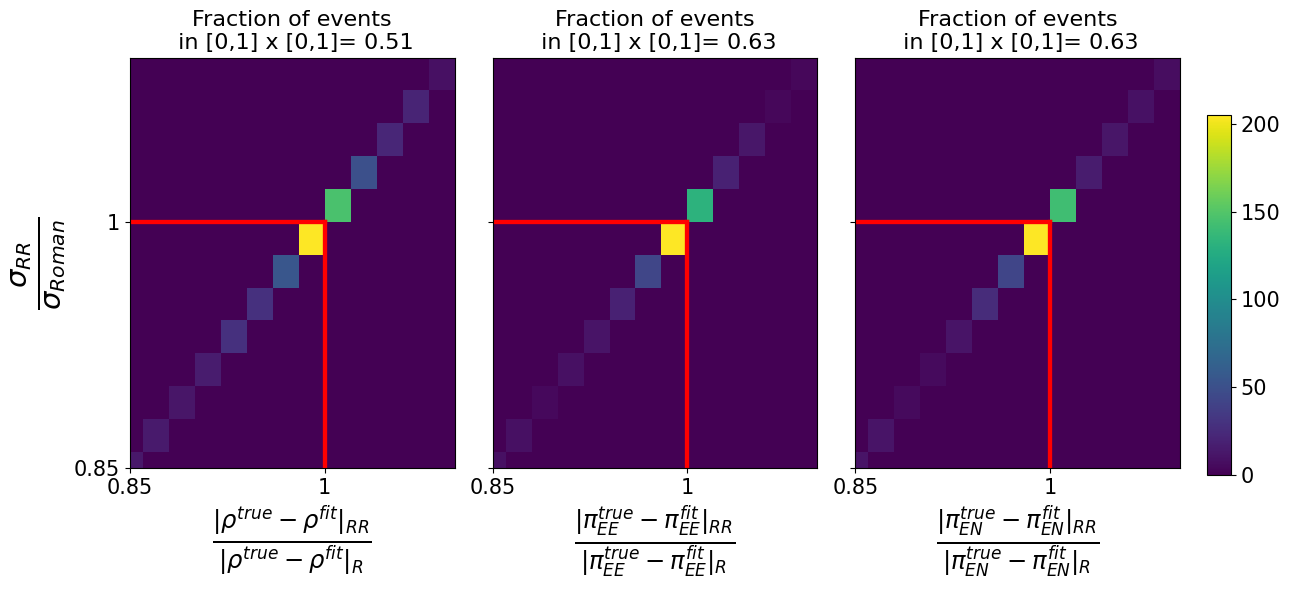

In [34]:
# def plot_comparisons(err_ratio, residuals_ratio,opsim,model):
%matplotlib inline
plt.close('all')
err_ratio, residuals_ratio,opsim,model = err_ratio, residuals_ratio, 'Baseline', 'PSPL'
fractions = []
labels = {'t0':'t_0', 'u0':'u_0', 'te':'t_E','rho':'\\rho', 's':'s', 'q':'q', 'alpha':'\\alpha', 'piEE':'\pi_{EE}', 'piEN':'\pi_{EN}', 'piE':'\pi_{E}'}
# Define your data and properties as given in your code
if 'PSPL' in model:
    properties = ('t0', 'u0', 'te','rho', 'piEE', 'piEN')
elif 'USPL' in model:
    properties = ('te','rho', 'piE')
else:
    properties = ('t0', 'u0', 'te','rho', 's', 'q', 'alpha', 'piEE', 'piEN')
fig, axs = plt.subplots(1,3, figsize=(12, 6),sharey=True)
cbar_axs = [fig.add_axes([1.01, 0.2, 0.02, 0.6])]#,  # Color bar for the first row
Categories = {'B':'Roman gap but Rubin season','C':'Rubin gap but Roman season','D':'Overlap seasons'}
n=1
for i, p in enumerate(properties):
    row, col = divmod(i, 3) 
    print(row, col)

    im = axs[col].hist2d(residuals_ratio[p]
                              , err_ratio[p], bins=[np.arange(0, 1.2, 0.02), np.arange(0., 1.2, 0.02)])
    # print(len(m1_ratio[p]))
    label_m1 = r'$\frac{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|_{RR}}{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|_{R}}$'#+f'{labels[p]}'+'^{true}}$'#+r'$\frac{|'+f'{p}'+'^{true}-'+f'{p}'+'^{fit}|_{RR}}{'+f'{p}'+'^{true}}$'
    axs[col].set_xlabel(label_m1,fontsize=25)
    axs[ col].set_xticks([0.85,1,1.15],[0.85,1,1.15],fontsize=15)
    axs[ col].set_yticks([0.85,1,1.15],[0.85,1,1.15],fontsize=15)
    # Calculate the number of events in [0,1] x [0,1] square
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
    axs[ col].plot(np.linspace(0.,1,15),np.ones(15),color='red',marker=' ', linestyle='-',lw=3)
    axs[ col].plot(np.ones(15),np.linspace(0.,1,15),color='red',marker=' ', linestyle='-',lw=3)
    axs[ col].plot(np.linspace(0.,1,15),np.ones(15)*0,color='red',marker=' ', linestyle='-',lw=3)
    axs[ col].plot(np.ones(15)*0,np.linspace(0.,1,15),color='red',marker=' ', linestyle='-',lw=3)

    df = err_ratio[(err_ratio[p]<y_max) & (err_ratio[p]>y_min)]
    # display(df)
#         # df0 = residuals_ratio[residuals_ratio['source'].isin(df_cat['source'][df_cat['cat']==cat].values.astype(int))]
    number_in_square = len(df[(df[p] <x_max) & (df[p] >x_min)])/len(residuals_ratio)

#         # Label for the text annotation
    text_x = 1  # X-coordinate for the text
    text_y = 0.4  # Y-coordinate for the text (negative to go below the figure)
    text = f"Fraction of events\n in [{x_min},{x_max}] x [{y_min},{y_max}]= {round(number_in_square ,2)}"  # Insert the number here
    axs[ col].set_title(text, fontsize = 16)

    if col == 0:
        axs[ col].set_ylabel(r'$\frac{ \sigma_{RR} }{\sigma_{Roman}}$',fontsize=30)

    axs[ col].set_xlim(0.85,1.1)
    axs[ col].set_ylim(0.85, 1.1)

    fig.colorbar(im[3], cax=cbar_axs[0])
    cbar = fig.colorbar(im[3], cax=cbar_axs[0])
    cbar.ax.tick_params(labelsize=15)
# plt.suptitle(opsim  +f' {model} - '+Categories[cat],fontsize=30)    
plt.tight_layout()
# plt.savefig(f'/home/anibal/FIGURES_roman_rubin/{model}_{opsim}_{cat}.png')
plt.show()

/tmp/ipykernel_5632/3350914641.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


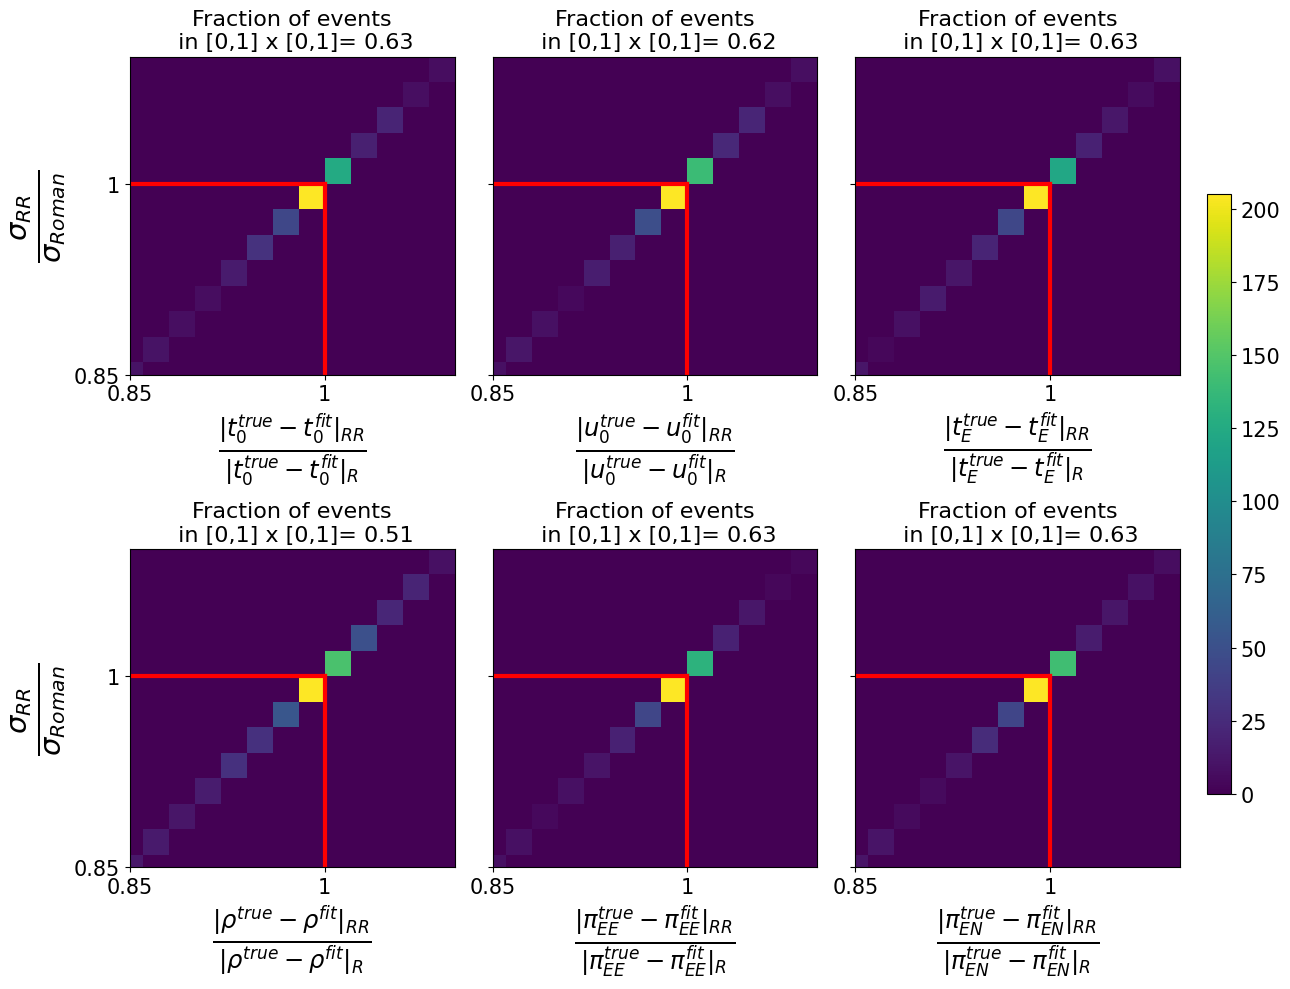

In [35]:
def plot_comparisons(err_ratio, residuals_ratio,opsim,model):
    fractions = []
    labels = {'t0':'t_0', 'u0':'u_0', 'te':'t_E','rho':'\\rho', 's':'s', 'q':'q', 'alpha':'\\alpha', 'piEE':'\pi_{EE}', 'piEN':'\pi_{EN}'}
    # Define your data and properties as given in your code
    if 'PSPL' in model:
        properties = ('t0', 'u0', 'te','rho', 'piEE', 'piEN')
    elif 'USPL' in model:
        properties = ('t0', 'u0', 'te','rho', 'piEE', 'piEN')
    else:
        properties = ('t0', 'u0', 'te','rho', 's', 'q', 'alpha', 'piEE', 'piEN')
    fig, axs = plt.subplots(2,3, figsize=(12, 10),sharey=True)
    cbar_axs = [fig.add_axes([1.01, 0.2, 0.02, 0.6])]#,  # Color bar for the first row
    Categories = {'B':'Roman gap but Rubin season','C':'Rubin gap but Roman season','D':'Overlap seasons'}
    n=1
    for i, p in enumerate(properties):
        row, col = divmod(i, 3)  # Calculate the row and column index for the current subplot
        # m1_ratio = met_1_ratio[met_1_ratio['source'].isin(df_cat['source'][df_cat['cat']==cat].values.astype(int))]
        # print(len(m1_ratio))
        im = axs[row, col].hist2d(residuals_ratio[p]
                                  , err_ratio[p], bins=[np.arange(0, 1.2, 0.02), np.arange(0., 1.2, 0.02)])
        # print(len(m1_ratio[p]))
        label_m1 = r'$\frac{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|_{RR}}{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|_{R}}$'#+f'{labels[p]}'+'^{true}}$'#+r'$\frac{|'+f'{p}'+'^{true}-'+f'{p}'+'^{fit}|_{RR}}{'+f'{p}'+'^{true}}$'
        axs[row, col].set_xlabel(label_m1,fontsize=25)
        axs[row, col].set_xticks([0.85,1,1.15],[0.85,1,1.15],fontsize=15)
        axs[row, col].set_yticks([0.85,1,1.15],[0.85,1,1.15],fontsize=15)
        # Calculate the number of events in [0,1] x [0,1] square
        x_min, x_max = 0, 1
        y_min, y_max = 0, 1
        axs[row, col].plot(np.linspace(0.,1,15),np.ones(15),color='red',marker=' ', linestyle='-',lw=3)
        axs[row, col].plot(np.ones(15),np.linspace(0.,1,15),color='red',marker=' ', linestyle='-',lw=3)
        axs[row, col].plot(np.linspace(0.,1,15),np.ones(15)*0,color='red',marker=' ', linestyle='-',lw=3)
        axs[row, col].plot(np.ones(15)*0,np.linspace(0.,1,15),color='red',marker=' ', linestyle='-',lw=3)

        df = err_ratio[(err_ratio[p]<y_max) & (err_ratio[p]>y_min)]
        # display(df)
#         # df0 = residuals_ratio[residuals_ratio['source'].isin(df_cat['source'][df_cat['cat']==cat].values.astype(int))]
        number_in_square = len(df[(df[p] <x_max) & (df[p] >x_min)])/len(residuals_ratio)
        
#         # Label for the text annotation
        text_x = 1  # X-coordinate for the text
        text_y = 0.4  # Y-coordinate for the text (negative to go below the figure)
        text = f"Fraction of events\n in [{x_min},{x_max}] x [{y_min},{y_max}]= {round(number_in_square ,2)}"  # Insert the number here
        axs[row, col].set_title(text, fontsize = 16)

        if col == 0:
            axs[row, col].set_ylabel(r'$\frac{ \sigma_{RR} }{\sigma_{Roman}}$',fontsize=30)

        axs[row, col].set_xlim(0.85,1.1)
        axs[row, col].set_ylim(0.85, 1.1)

        fig.colorbar(im[3], cax=cbar_axs[0])
        cbar = fig.colorbar(im[3], cax=cbar_axs[0])
        cbar.ax.tick_params(labelsize=15)
    # plt.suptitle(opsim  +f' {model} - '+Categories[cat],fontsize=30)    
    plt.tight_layout()
    # plt.savefig(f'/home/anibal/FIGURES_roman_rubin/{model}_{opsim}_{cat}.png')
    plt.show()

cat = 'B'
plot_comparisons(err_ratio, residuals_ratio, 'Baseline', 'PSPL')

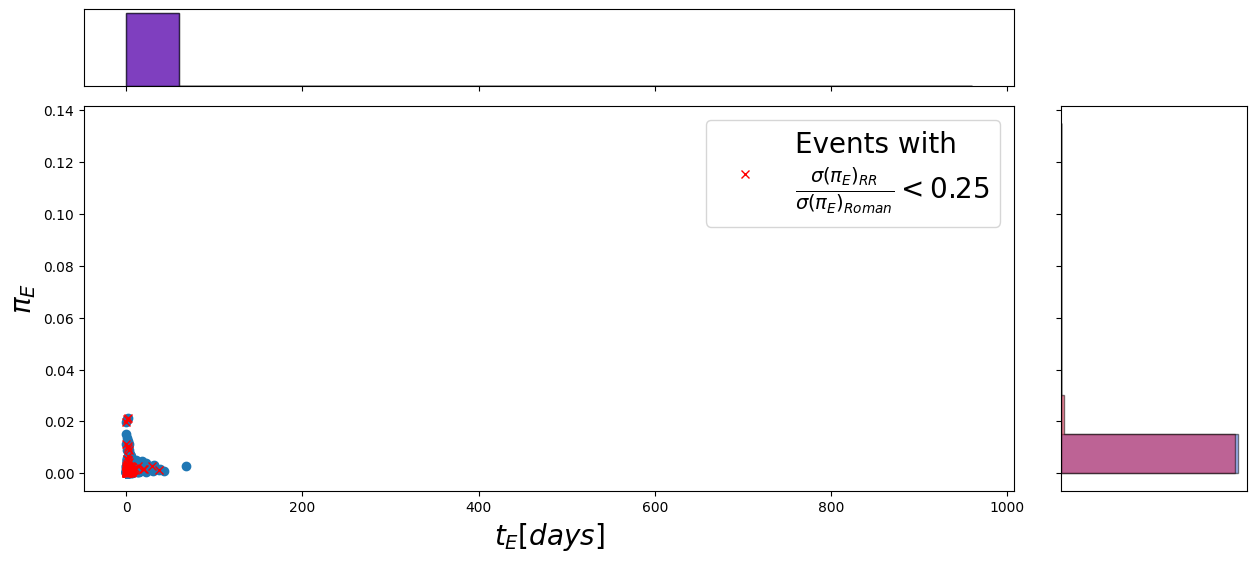

In [36]:
#x = residuals_ratio['te']
labelsparams = lambda p: labels[p]
label_m3 = lambda p :r'$\frac{\sigma_{'+f'{labels[p]}'+'}}{'+f'{labels[p]}'+'^{fit}}$'#+f'{labels[p]}'+'}}$'
label_m2 = lambda p :r'$\frac{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|}{\sigma_{'+f'{labels[p]}'+'}}$'
fig, ax = plt.subplots(1, 1, figsize = (12, 5), sharey=True, gridspec_kw={'width_ratios': [1]})

q='te'
ax.plot(true['te'],true['piE'],marker='o',ls='')#,bins=np.linspace(min(true[q]), max(true[q]),15))
ax.plot(true['te'][true['Source'].isin(err_ratio['Source'][err_ratio['piE']<0.25])], true['piE'][true['Source'].isin(err_ratio['Source'][err_ratio['piE']<0.25])],marker='x',ls='',color='red',label='Events with\n'+r'$\frac{\sigma(\pi_E)_{RR}}{\sigma(\pi_E)_{Roman}}<0.25$')#,bins=np.linspace(min(true[q]), max(true[q]),15))
ax.set_xlabel(r'$t_E [days]$',fontsize=20)
ax.set_ylabel(r'$\pi_E$',fontsize=20)

ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)

# Histogram settings
#binwidth = 0.1
ax_histx.hist(true['te'], bins=np.arange(0, 1000, 60), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='red')
ax_histx.hist(true['te'][true['Source'].isin(err_ratio['Source'][err_ratio['piE']<0.25])], bins=np.arange(0, 1000, 60), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='blue')

ax_histy.hist(true['piE'], bins=np.arange(0, 0.15, 0.015), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='royalblue', orientation='horizontal')
ax_histy.hist(true['piE'][true['Source'].isin(err_ratio['Source'][err_ratio['piE']<0.25])], bins=np.arange(0, 0.15, 0.015), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='crimson', orientation='horizontal')

#ax_histy.set_xscale("log")
# Remove ticks from inset histograms
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.tick_params(axis="y", left=False, labelleft=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="x", bottom=False, labelbottom=False)
ax.legend(loc='best',fontsize=20)


In [37]:
labelsparams = lambda p: labels[p]

label_m3 = lambda p :r'$\frac{\sigma_{'+f'{labels[p]}'+'}}{'+f'{labels[p]}'+'^{fit}}$'#+f'{labels[p]}'+'}}$'
label_m2 = lambda p :r'$\frac{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|}{\sigma_{'+f'{labels[p]}'+'}}$'


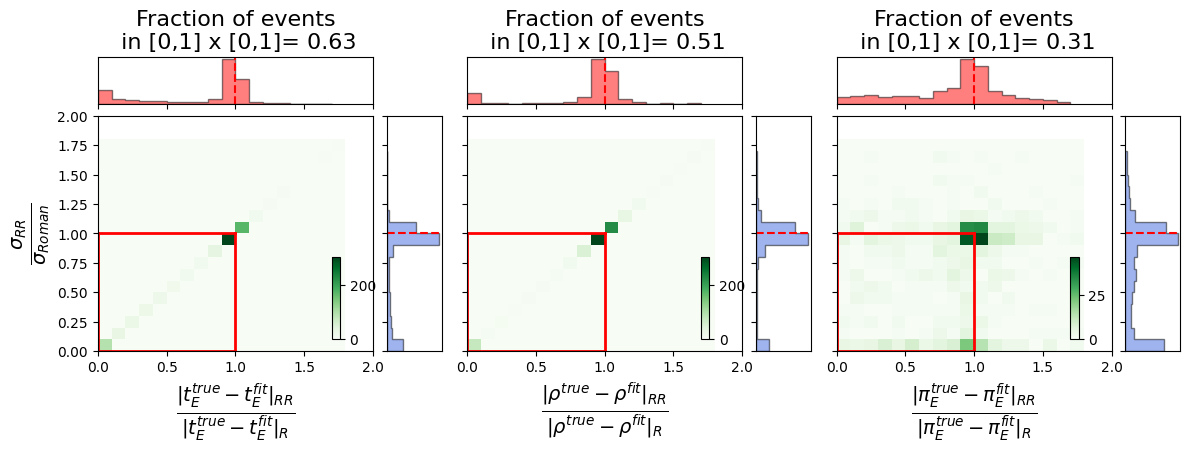

In [38]:
labels = {'t0':'t_0', 'u0':'u_0', 'te':'t_E','rho':'\\rho', 's':'s', 'q':'q', 'alpha':'\\alpha', 'piE':'\pi_{E}', 'piEN':'\pi_{EN}'}

def create_hist2d_with_marginals(ax, x, y, labels, p, first_col=False):
    # Main scatter plot
    hb = ax.hist2d(x, y, bins=(np.arange(0, 1.9, 0.1), np.arange(0, 1.9, 0.1)), cmap='Greens')
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)

    # Create inset axes for the histograms
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
    ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)

    # Histogram settings
    binwidth = 0.1
    ax_histx.hist(x, bins=np.arange(0, 1.8, binwidth), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='red')
    ax_histy.hist(y, bins=np.arange(0, 1.8, binwidth), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='royalblue', orientation='horizontal')

    # Remove ticks from inset histograms
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", left=False, labelleft=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="x", bottom=False, labelbottom=False)
    # ax_histy.set_yscale("log")
    # Add vertical and horizontal lines
    ax_histx.axvline(1, color='red', ls='--')
    ax_histy.axhline(1, color='red', ls='--')
    ax.axvline(1, ymin=0, ymax=0.5, lw=2, color='red')
    ax.axvline(0, ymin=0, ymax=0.5, lw=2, color='red')
    ax.axhline(0, xmin=0, xmax=0.5, lw=2, color='red')
    ax.axhline(1, xmin=0, xmax=0.5, lw=2, color='red')

    # Set labels with LaTeX formatting
    label_m1 = lambda p: r'$\frac{|' + f'{labels[p]}' + r'^{true}-' + f'{labels[p]}' + r'^{fit}|_{RR}}{|' + f'{labels[p]}' + r'^{true}-' + f'{labels[p]}' + r'^{fit}|_{R}}$'
    label_m2 = r'$\frac{\sigma_{RR}}{\sigma_{Roman}}$'

    ax.set_xlabel(label_m1(p), fontsize=20)
    
    # ax.set_xlabel("a",fontsize=20)
    if first_col:
        ax.set_ylabel(label_m2, fontsize=20)

    # Add a colorbar inside the main plot
    cax = ax.inset_axes([0.85, 0.05, 0.03, 0.35], transform=ax.transAxes)
    cbar = plt.colorbar(hb[3], cax=cax, orientation='vertical')
    # cax.set_yticks([0, 50, 1000])
    # cax.set_yticklabels([0, 100, 2000], fontsize=8)
    x_min=0
    x_max=1
    y_min=0
    y_max=1
    fil_x= x[(y<1)&(y>0)]
    filtered=fil_x[(fil_x<1)&(fil_x>0)]

    number_in_square = len(filtered)/len(y)
    text = f"Fraction of events\n in [{x_min},{x_max}] x [{y_min},{y_max}]= {round(number_in_square ,2)}"  # Insert the number here
    ax.set_title(text, fontsize = 16)

# Example usage
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [1,1, 1]})
x = residuals_ratio['te']
y = err_ratio['te']
x2 = residuals_ratio['rho']
y2 = err_ratio['rho']
x3 = residuals_ratio['piE']
y3 = err_ratio['piE']

create_hist2d_with_marginals(axes[0], x, y, labels, 'te', first_col=True)
create_hist2d_with_marginals(axes[1], x2, y2, labels, 'rho')
create_hist2d_with_marginals(axes[2], x3, y3, labels, 'piE')

plt.tight_layout()
plt.show()

The MSE is defined as 
$$MSE(\hat{\theta}) = bias(\hat{\theta}) + Var(\hat{\theta}) $$

In [39]:
print(len(true))
print(len(fit_rr))
print(len(fit_roman))

812
812
812


35.3448275862069


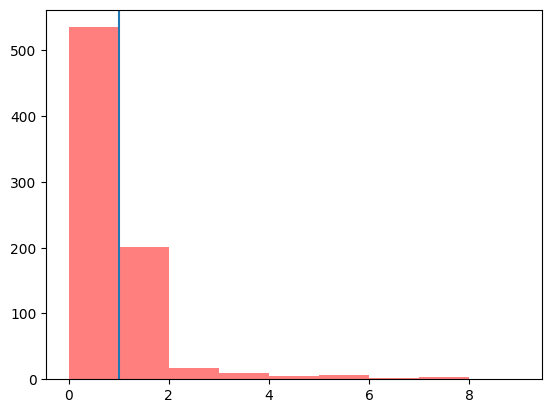

In [40]:
p='piE'

MSE_rr = abs(fit_rr[p]-true[p]) + fit_rr[p+'_err']**2
MSE_roman = abs(fit_roman[p]-true[p]) + fit_roman[p+'_err']**2
MSE_ratio = MSE_rr/MSE_roman
print(100*len(MSE_ratio[MSE_ratio<0.5])/len(MSE_ratio))
plt.hist(MSE_ratio,bins=np.arange(0,10,1),color='red',alpha=0.5)
plt.axvline(1)
# plt.hist(,bins=np.arange(0,0.05,0.001),alpha=0.5,color='blue')
# plt.hist()
plt.show()

### bias/true

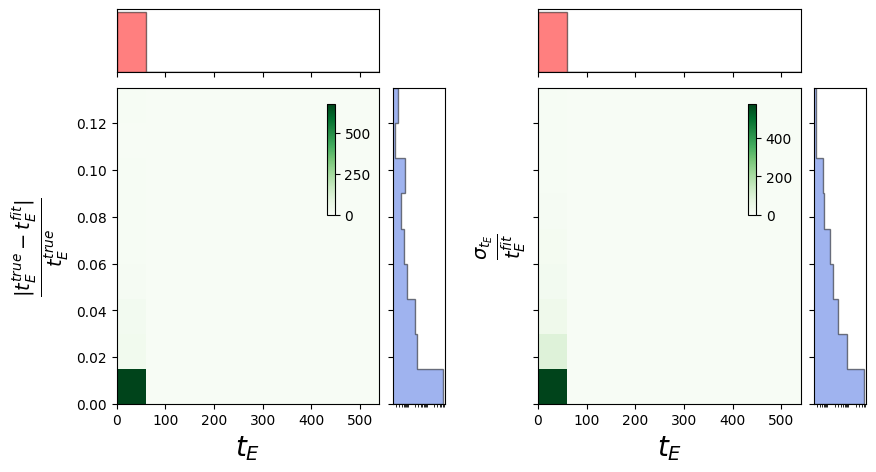

In [41]:
labelsparams = lambda p: labels[p]
labels = {'t0':'t_0', 'u0':'u_0', 'te':'t_E','rho':'\\rho', 's':'s', 'q':'q', 'alpha':'\\alpha', 'piE':'\pi_{E}', 'piEN':'\pi_{EN}'}
label_m1 = lambda p: r'$\frac{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|}{'+f'{labels[p]}'+'^{true}'+'}$'
label_m3 = lambda p :r'$\frac{\sigma_{'+f'{labels[p]}'+'}}{'+f'{labels[p]}'+'^{fit}}$'#+f'{labels[p]}'+'}}$'
label_m2 = lambda p :r'$\frac{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|}{\sigma_{'+f'{labels[p]}'+'}}$'

def create_hist2d_with_marginals(ax, x, y, ylabel_func,xlabel_func, p, first_col=False):
    # Main scatter plot
    hb = ax.hist2d(x, y, bins=(np.arange(0, 600, 60), np.arange(0, 0.15, 0.015)), cmap='Greens')
    # Create inset axes for the histograms
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
    ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
    # Histogram settings
    binwidth = 0.1
    ax_histx.hist(x, bins=np.arange(0, 600, 60), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='red')
    ax_histy.hist(y, bins=np.arange(0, 0.15, 0.015), density=True, histtype='stepfilled', edgecolor='k', fill=True, alpha=0.5, color='royalblue', orientation='horizontal')
    ax_histy.set_xscale("log")
    # Remove ticks from inset histograms
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", left=False, labelleft=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="x", bottom=False, labelbottom=False)
    # Add vertical and horizontal lines
    ax_histx.axvline(1, color='red', ls='--')
    ax_histy.axhline(1, color='red', ls='--')
    # Set labels with LaTeX formatting
    label_m1 = lambda p: r'$\frac{|' + f'{labels[p]}' + r'^{\text{true}}-' + f'{labels[p]}' + r'^{\text{fit}}|_{RR}}{|' + f'{labels[p]}' + r'^{\text{true}}-' + f'{labels[p]}' + r'^{\text{fit}}|_{R}}$'
    label_m2 = r'$\frac{\sigma_{RR}}{\sigma_{\text{Roman}}}$'

    ax.set_ylabel(ylabel_func(p), fontsize=20)
    ax.set_xlabel(f'${xlabel_func(p)}$', fontsize=20)
    cax = ax.inset_axes([0.8, 0.6, 0.03, 0.35], transform=ax.transAxes)
    cbar = plt.colorbar(hb[3], cax=cax, orientation='vertical')

fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True, gridspec_kw={'width_ratios': [1, 1]})
x = residuals_ratio['te']
y = err_ratio['te']
# x2 = residuals_ratio['rho']
# y2 = err_ratio['rho']
x3 = residuals_ratio['piE']
y3 = err_ratio['piE']

p='te'
create_hist2d_with_marginals(axes[0], fit_rr[p], met_1_rr[p], label_m1, labelsparams, 'te', first_col=True)
# create_hist2d_with_marginals(axes[1], fit_rr[p], met_2_rr[p], label_m2, labelsparams, 'te')
create_hist2d_with_marginals(axes[1], fit_rr[p], met_3_rr[p], label_m3, labelsparams, 'te')
# create_hist2d_with_marginals(axes[1], x2, y2, labels, 'rho')
# create_hist2d_with_marginals(axes[2], x3, y3, labels, 'piE')

plt.tight_layout()
plt.show()

In [42]:
# met_1_roman

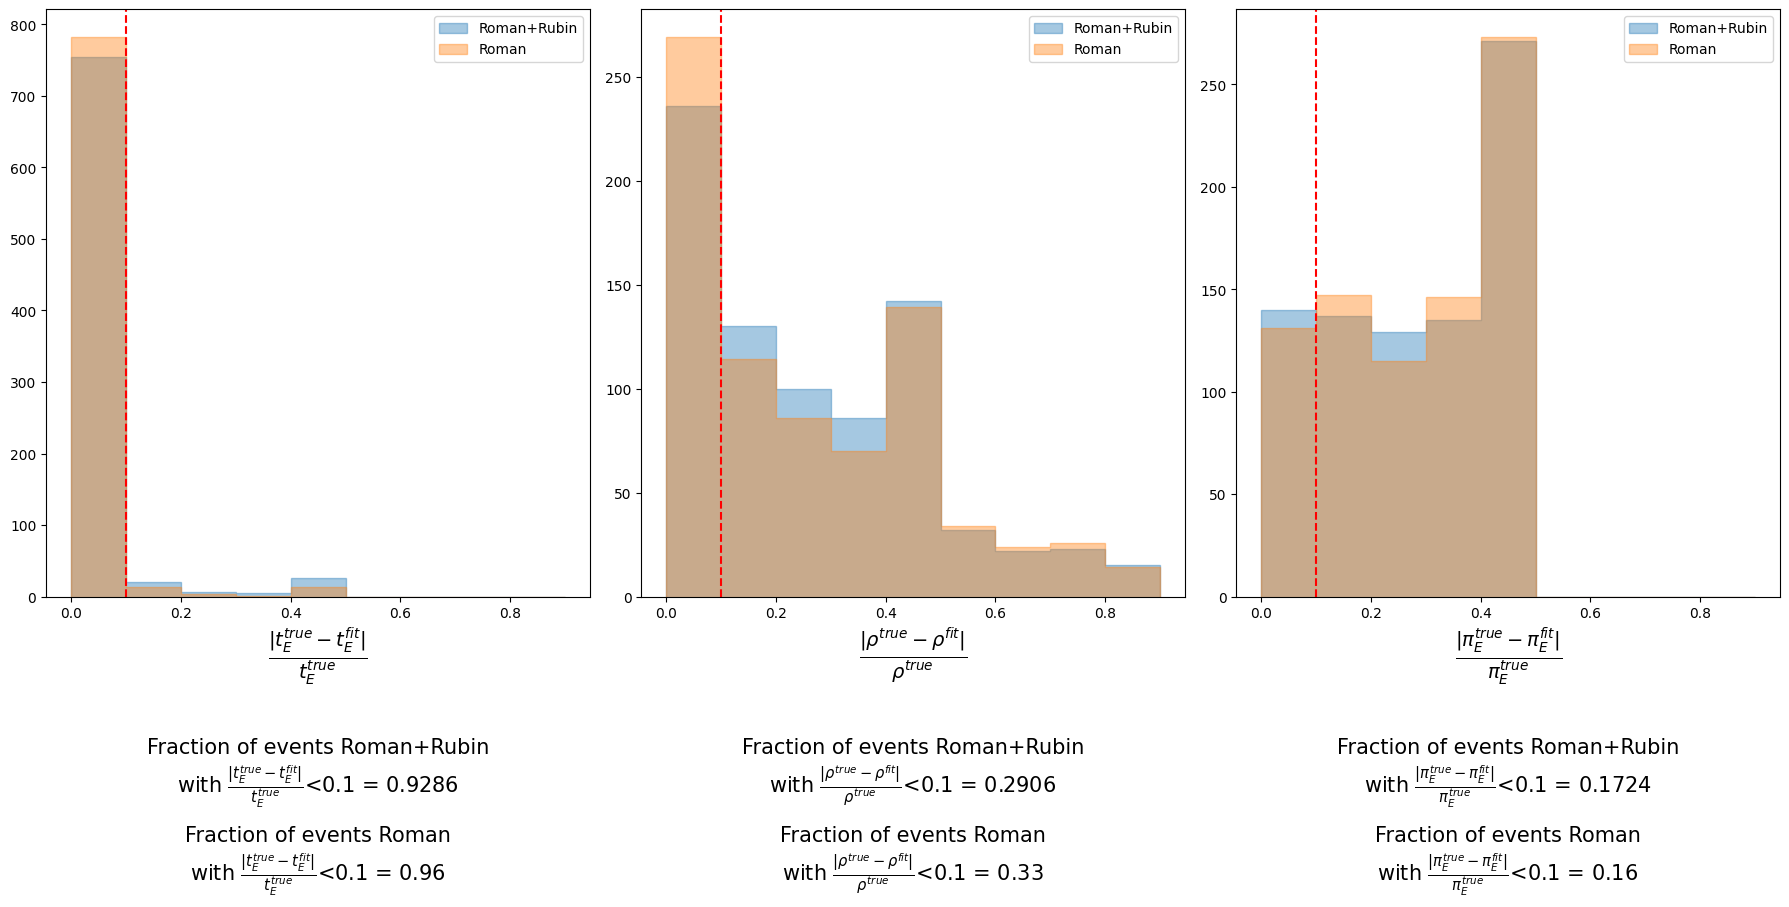

In [43]:

cats_labels = {'A': 'Overlap seasons Roman and Rubin', 'B': 'Roman gap and Rubin season','C': 'gap Roman and gap Rubin', 'D': 'Season Roman and gap Rubin'}
# Function to plot histograms and annotations
def plot_histogram(ax, data1, data2, xlabel, title, bins1, bins2):
    # ax.set_title(title)
    ax.hist(data1, bins=bins1, fill=True, alpha=0.4, histtype='step', label='Roman+Rubin')
    ax.hist(data2, bins=bins2, fill=True, alpha=0.4, histtype='step', label='Roman')
    ax.set_xlabel(xlabel, fontsize=20)
    ax.axvline(0.1, color='red', linestyle='--')
    ax.legend(loc='best')
    
    fraction_data1 = len(data1[data1 < 0.1]) / len(data1)
    fraction_data2 = len(data2[data2 < 0.1]) / len(data2)
    
    ax.annotate(f'Fraction of events Roman+Rubin\nwith {xlabel}<0.1 = {round(fraction_data1,4)}', 
                xy=(0.5, -0.3), xycoords='axes fraction',
                ha='center', va='center', fontsize=15)
    ax.annotate(f'Fraction of events Roman\nwith {xlabel}<0.1 = {fraction_data2:.2f}', 
                xy=(0.5, -0.45), xycoords='axes fraction',
                ha='center', va='center', fontsize=15)

    

fig, axes = plt.subplots(1, 3, figsize=(18, 10))
bins1, bins2 = np.arange(0,1,0.1), np.arange(0,1,0.1)
# Si quiero ver una categoria en particular
cat = 'A'
# plt.suptitle(f'Category: {cats_labels[cat]}')

mask = met_1_rr['Source'].isin(true['Source'][true['categories']==cat])
# Plot for 'te'
p = 'te'
plot_histogram(axes[0], met_1_rr[p], met_1_roman[p], label_m1(p), f'${labels[p]}$', bins1, bins2)

# # Plot for 'rho'
q = 'rho'
plot_histogram(axes[1], met_1_rr[q], met_1_roman[q], label_m1(q), f'${labels[q]}$', bins1, bins2)

r = 'piE'
lab_m1_piE = r'$\frac{|\pi_E^{true}-\pi_E^{fit}|}{\pi_E^{true}}$'
plot_histogram(axes[2], met_1_rr[r], met_1_roman[r], lab_m1_piE, f'$\pi_E$', bins1, bins2)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


### bias/sigma

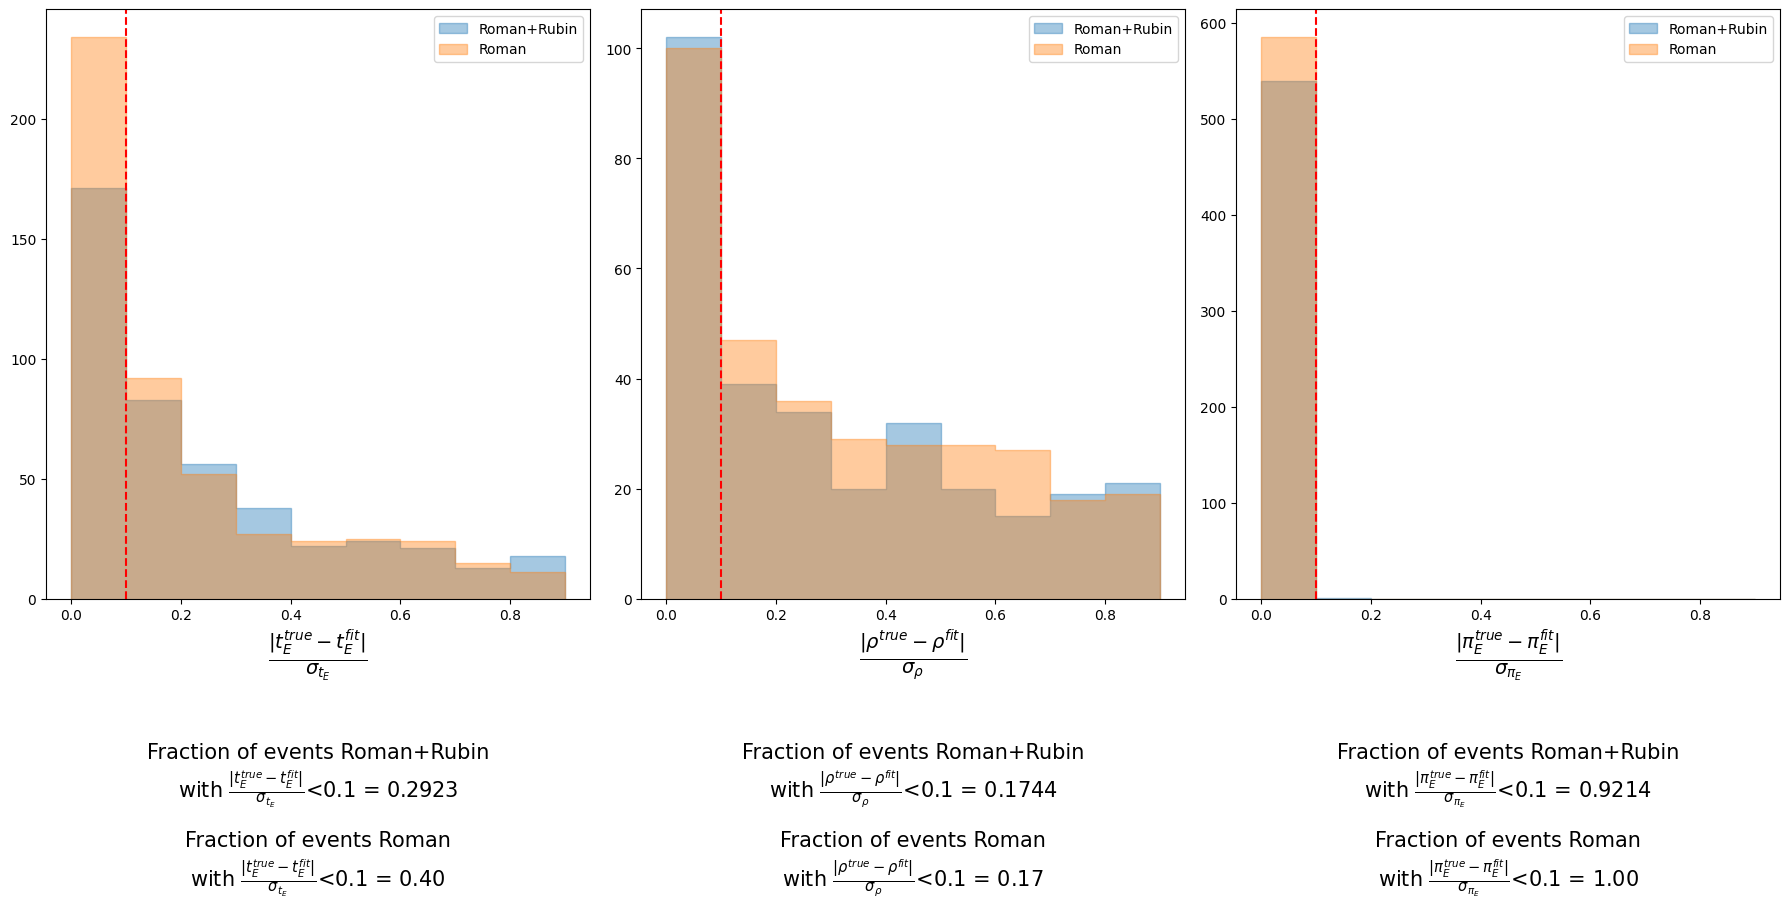

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))
cat = 'A'
mask = met_2_rr['Source'].isin(true['Source'][true['categories']==cat])
# Plot for 'te'
p = 'te'
plot_histogram(axes[0], met_2_rr[p][mask], met_2_roman[p][mask], label_m2(p), f'${labels[p]}$', bins1,bins2)
r = 'rho'
plot_histogram(axes[1], met_2_rr[r][mask], met_2_roman[r][mask],label_m2(r), f'${labels[r]}$', bins1,bins2)
r = 'piE'
plot_histogram(axes[2], met_2_rr[r][mask], met_2_roman[r][mask], r'$\frac{|\pi_E^{true}-\pi_E^{fit}|}{\sigma_{\pi_E}}$', f'$\pi_E$', bins1,bins2)
# plt.suptitle(f'Category: {cats_labels[cat]}')
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### relative error

68.05779926151953

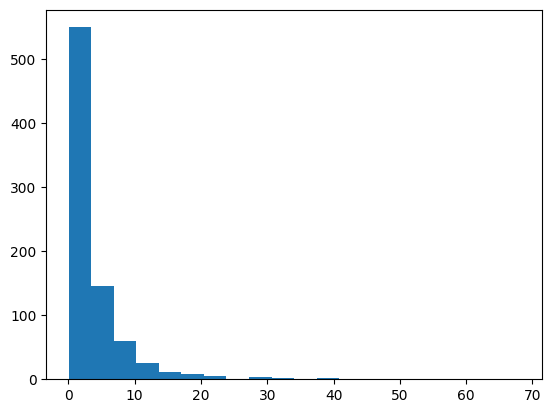

In [45]:
plt.hist(true['te'],bins=20)
min(true['te'])#[true['te']>4]
max(true['te'])

In [46]:
true[true['te']>25]

,Source,t0,u0,te,rho,piEN,piEE,categories,piE
149,6187,2.462605e+06,0.746279,29.668553,0.007124,0.001124,-0.000027,A,0.001124
182,6560,2.462646e+06,0.251659,30.463227,0.018750,0.000373,0.000664,A,0.000761
197,6688,2.462411e+06,0.926024,37.569209,0.012457,0.001055,0.000047,B,0.001056
242,9075,2.462634e+06,0.033835,31.186545,0.154022,0.001684,-0.002245,A,0.002807
301,14369,2.462739e+06,0.186668,38.000837,0.050167,0.001132,0.001387,A,0.001790
331,10470,2.461697e+06,0.579054,42.452876,0.045693,0.000757,0.000494,A,0.000903
409,11042,2.462006e+06,0.342688,68.057799,0.017089,0.000505,0.002868,B,0.002913
593,17861,2.461927e+06,0.789738,31.341290,0.035796,0.002986,-0.000328,B,0.003004
798,23706,2.462342e+06,0.006792,28.853172,0.104550,0.001428,0.002222,B,0.002641


In [47]:
# read_curves(os.listdir(path+'set_sim1/')[0])


In [48]:
# plt.hist(met_3_rr['piE'])
# plt.yscale('log')


In [49]:
# print(len(met_3_rr['piE'][met_3_rr['piE']<0.1]))

# print(len(met_3_rr['piE'][met_3_rr['piE']<0.1]))

In [50]:
# plt.hist(met_3_rr['piE'],bins=np.arange(0,1,0.10))
# plt.yscale('log')

In [51]:
# met_3_rr[r2][met_3_rr[r2]<0.1]

In [52]:
# plt.hist(met_3_rr[r2],bins=np.arange(-0.1,1,0.1))#[met_3_rr[r2]<0.1]#/len(met_3_rr[r2])
# plt.hist(met_3_rr[r2][met_3_rr[r2]<0.1],bins=np.arange(-0.1,1,0.1))

In [53]:
print(met_3_roman[met_3_roman['Source']==24789])
print(met_3_roman[met_3_rr['Source']==24789])

Empty DataFrame
Columns: [Source, t0, u0, te, rho, piEN, piEE, piE]
Index: []
Empty DataFrame
Columns: [Source, t0, u0, te, rho, piEN, piEE, piE]
Index: []


(array([93., 78., 74., 77., 86., 93., 71., 78., 80., 82.]),
 array([0.00228574, 0.10202026, 0.20175479, 0.30148932, 0.40122384,
        0.50095837, 0.6006929 , 0.70042742, 0.80016195, 0.89989648,
        0.999631  ]),
 <BarContainer object of 10 artists>)

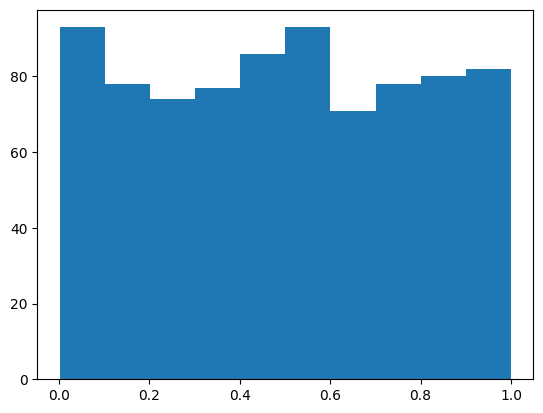

In [54]:
plt.hist(true['u0'])

In [55]:
met_3_rr['piEE']


0      60798.312867
1          0.000000
2      34595.832784
3         99.516498
4      28516.309618
           ...     
807     1607.144252
808    35109.656851
809     6907.119214
810      205.039012
811     2106.246497
Name: piEE, Length: 812, dtype: float64

In [136]:
path

'/home/anibal/results_roman_rubin/FFP_final/FFP/'

In [57]:
data_fit = np.load(path+f'set_fit1/Event_RR_{9097-5000}_TRF.npy',allow_pickle=True).item()


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

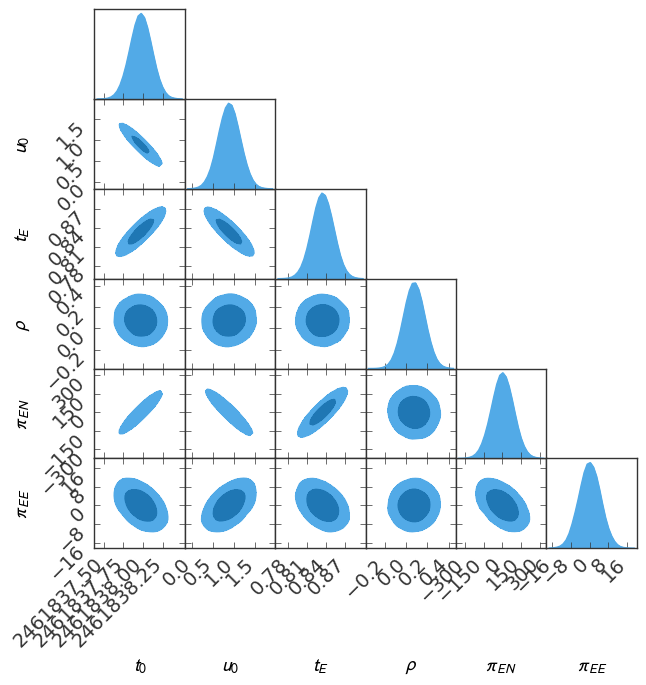

In [128]:
import pygtc

mean_for_sampling = data_fit["best_model"][0:6]
cov_for_sampling = data_fit['covariance_matrix'][0:6,0:6]
n_samples_plot = 30000

samples = np.random.multivariate_normal(mean_for_sampling, cov_for_sampling, n_samples_plot)

names = ['$t_0$',
         '$u_0$', '$t_{E}$', '$\\rho$','$\\pi_{EN}$', '$\\pi_{EE}$']#,'$F_S$', '$F_B$']
GTC = pygtc.plotGTC(chains=np.array(samples),
                    paramNames=names,
                    figureSize=7,
                   customLabelFont={'family':'Arial', 'size':14},
                   customLegendFont={'family':'Arial', 'size':14},
                   customTickFont={'family':'Arial', 'size':14})
plt.show()

In [135]:
# print(fit_roman[fit_roman['Source']==9097]['piE'])
# print(fit_roman[fit_roman['Source']==9097]['piEN'])
# print(fit_roman[fit_roman['Source']==9097]['piEE'])

# print(fit_rr[fit_rr['Source']==9097]['piE'])
# print(fit_rr[fit_rr['Source']==9097]['piEN'])
# print(fit_rr[fit_rr['Source']==9097]['piEE'])
print(met_3_rr[met_3_rr['Source']==9097]['piE'])

0    170829.560966
Name: piE, dtype: float64


(array([2.0000e+00, 2.1000e+01, 3.8900e+02, 2.5030e+03, 7.7230e+03,
        1.0452e+04, 6.6570e+03, 1.9790e+03, 2.5900e+02, 1.5000e+01]),
 array([-22.00029499, -17.93849421, -13.87669344,  -9.81489266,
         -5.75309189,  -1.69129111,   2.37050966,   6.43231043,
         10.49411121,  14.55591198,  18.61771276]),
 <BarContainer object of 10 artists>)

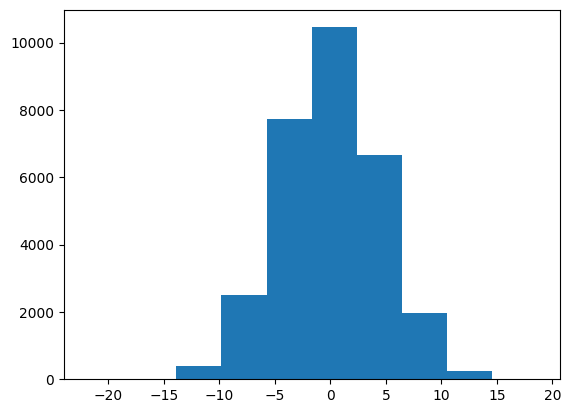

In [130]:
plt.hist(piEE_dist)

-0.13923507572567687
0.01149750288644968


Text(0.5, 0, '\\pi_E')

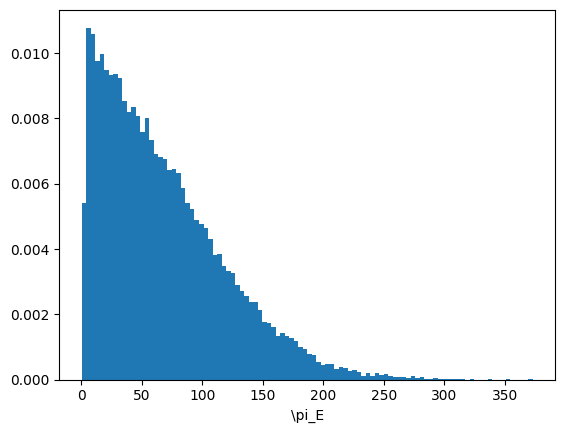

In [131]:
piEN_dist = np.array(samples)[:,4]
piEE_dist = np.array(samples)[:,5]
piE_dist = np.sqrt(piEN_dist**2+piEE_dist**2)
print(np.mean(piEN_dist))
print(np.mean(piEE_dist))
# plt.hist(piEN_dist)
# plt.hist(piEE_dist)
plt.hist(piE_dist,bins=100, density=True)
plt.xlabel('\pi_E')

In [97]:
# piE_dist

67.68447266502449
50.839774791723386


<BarContainer object of 124 artists>

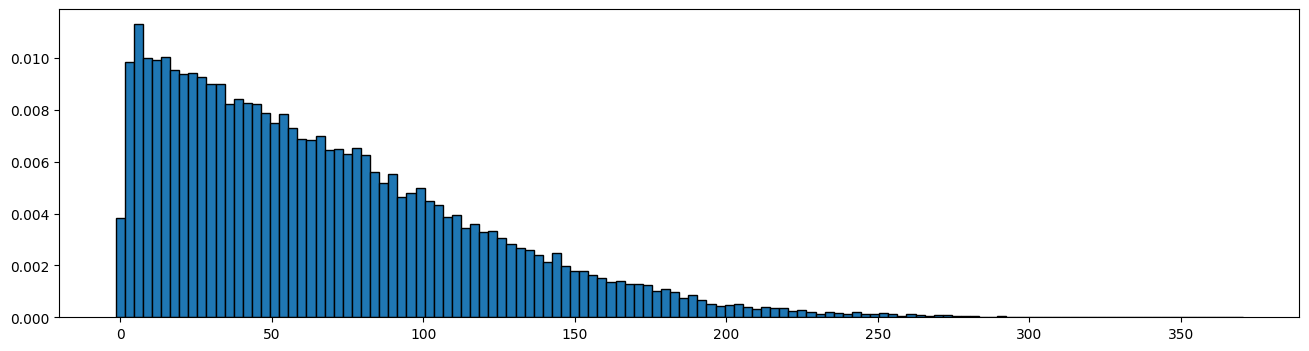

In [132]:
Y, bins = np.histogram(piE_dist, bins=np.arange(0, piE_dist.max(),3),density=True) # Genero el histograma
print(np.mean(piE_dist))
print(np.std(piE_dist))
f, ax = plt.subplots(ncols=1, figsize=(16,4), sharey=True)
f.subplots_adjust(wspace=0.05)

ax.bar(bins[:-1], Y, width=3, ec='k') 

Mean: 67.67580586019534
Standard Deviation: 50.815831866542545


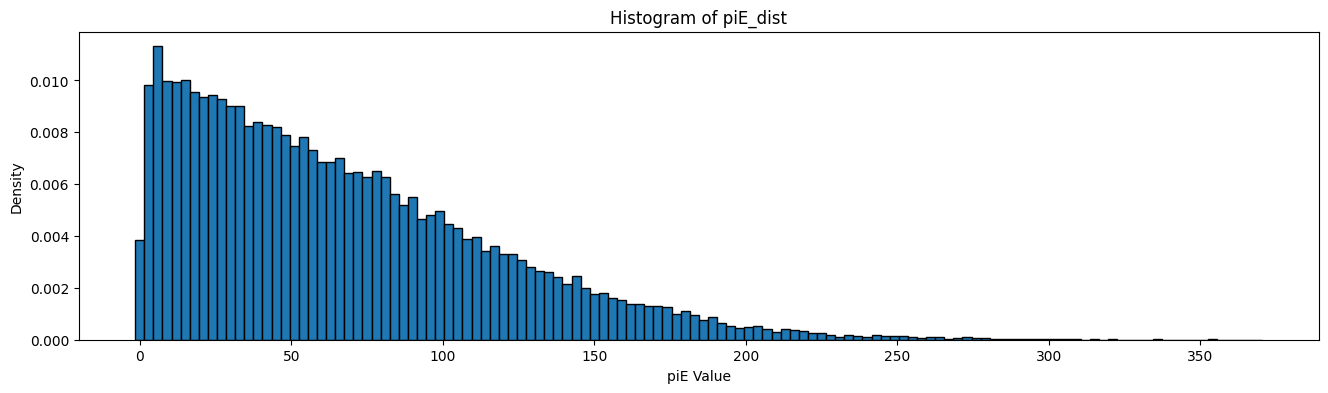

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Example piE_dist data
# piE_dist = np.random.normal(loc=5, scale=2, size=1000)  # Example distribution data

# Step 1: Generate the histogram
Y, bins = np.histogram(piE_dist, bins=np.arange(0, piE_dist.max(), 3), density=True)

# Step 2: Compute bin centers and widths
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_widths = np.diff(bins)

# Step 3: Compute the mean (μ)
mean = np.sum(bin_centers * Y * bin_widths)

# Step 4: Compute the variance (σ²)
variance = np.sum((bin_centers - mean) ** 2 * Y * bin_widths)

# Step 5: Compute the standard deviation (σ)
std_dev = np.sqrt(variance)

# Print results
print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")

# Plot the histogram
f, ax = plt.subplots(ncols=1, figsize=(16, 4), sharey=True)
f.subplots_adjust(wspace=0.05)
ax.bar(bins[:-1], Y, width=3, edgecolor='k')
ax.set_title('Histogram of piE_dist')
ax.set_xlabel('piE Value')
ax.set_ylabel('Density')

plt.show()


<StemContainer object of 3 artists>

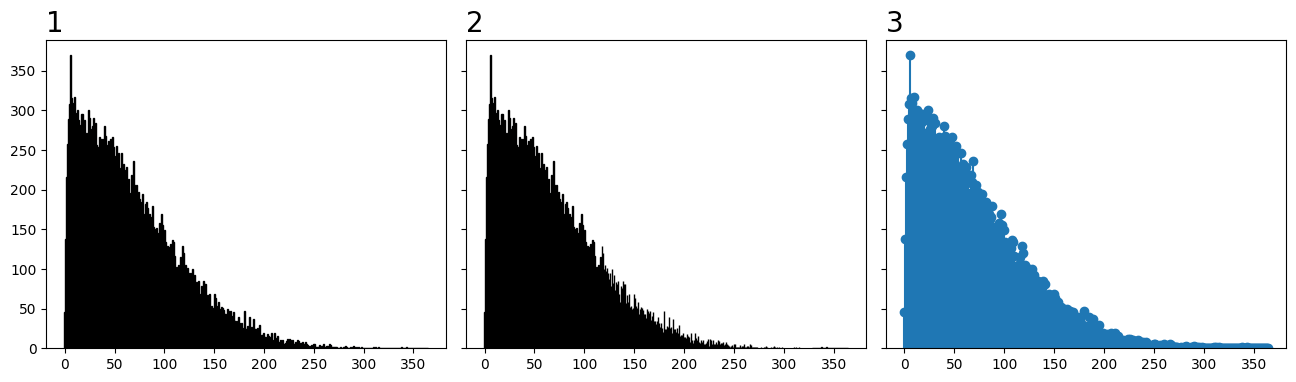

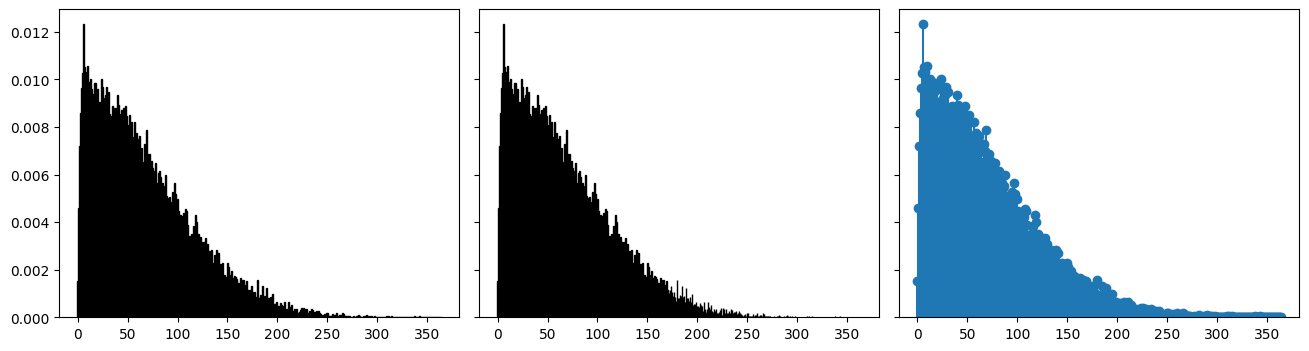

In [70]:
Y, bins = np.histogram(piE_dist, bins=np.arange(0, piE_dist.max())) # Genero el histograma
f, ax = plt.subplots(ncols=3, figsize=(16,4), sharey=True)
f.subplots_adjust(wspace=0.05)

ax[0].bar(bins[:-1], Y, width=1, ec='k') # Grafico el histograma (gráfico de barras)
ax[1].bar(bins[:-1], Y, width=0.5, ec='k')
ax[2].stem(bins[:-1], Y, basefmt=' ') # Stem-plot

for k, a in enumerate(ax, 1):
    a.set_title(k, loc='left', fontsize=20)
    
Y_normed = Y / np.sum(Y)

f, ax = plt.subplots(ncols=3, figsize=(16,4), sharey=True)
f.subplots_adjust(wspace=0.05)

ax[0].bar(bins[:-1], Y_normed, width=1, ec='k')
ax[1].bar(bins[:-1], Y_normed, width=0.5, ec='k')
ax[2].stem(bins[:-1], Y_normed, basefmt=' ')


# for k, a in enumerate(ax, 1):
#     a.scatter(bins[:-1], X.pmf(bins[:-1]), color='red', zorder=3)
#     a.set_title(k, loc='left', fontsize=20)

In [114]:
import numpy as np

# Example bin_edges and bin_counts from a histogram
bin_edges = np.array([0, 1, 2, 3, 4, 5])
bin_counts = np.array([10, 50, 80, 40, 20])

# Step 1: Compute bin centers and bin widths
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_widths = np.diff(bin_edges)

# Step 2: Total counts and normalize the histogram
N = np.sum(bin_counts)
prob_density = bin_counts / (N * bin_widths)

# Step 3: Compute the mean
mean = np.sum(bin_centers * prob_density)

# Step 4: Compute the variance
variance = np.sum((bin_centers - mean)**2 * prob_density)

# Step 5: Standard deviation
std_dev = np.sqrt(variance)

print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")


Mean: 2.5500000000000003
Standard Deviation: 1.023474474522936


In [116]:
import numpy as np
import scipy.stats as stats

# Sample data
data = piE_dist#np.array([10, 12, 9, 11, 15, 14, 13, 16, 12, 10])

# Parameters
confidence_level = 0.95  # 95% confidence interval

# Sample statistics
mean = np.mean(data)
std_dev = np.std(data, ddof=1)  # Sample standard deviation
n = len(data)

# Critical value from t-distribution (use z-distribution if sample size is large)
# critical_value = stats.t.ppf((1 + confidence_level) / 2, df=n-1)
critical_value = stats.norm.ppf((1 + confidence_level) / 2)

# Standard error of the mean
standard_error = std_dev/np.sqrt(n)

# Margin of error
margin_of_error = critical_value*standard_error

# Confidence interval
lower_bound = mean - margin_of_error
upper_bound = mean + margin_of_error

print(f"Mean: {mean}")
print(f"Standard Error: {standard_error}")
print(f"Margin of Error: {margin_of_error}")
print(f"{confidence_level*100}% Confidence Interval: ({lower_bound}, {upper_bound})")

Mean: 4.9113103713691855
Standard Error: 0.061573998371027595
Margin of Error: 0.12068281919134205
95.0% Confidence Interval: (4.790627552177844, 5.031993190560527)


In [168]:
# best_fit


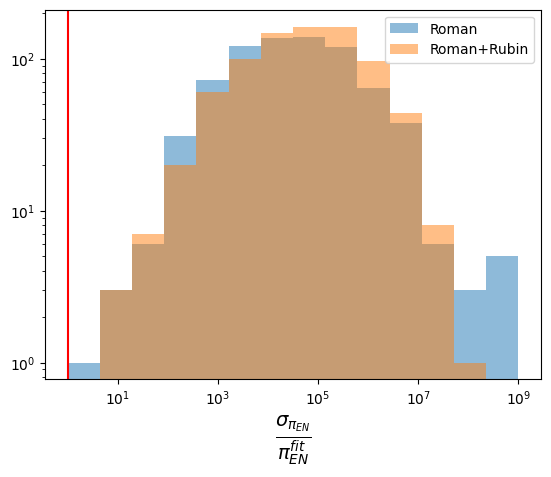

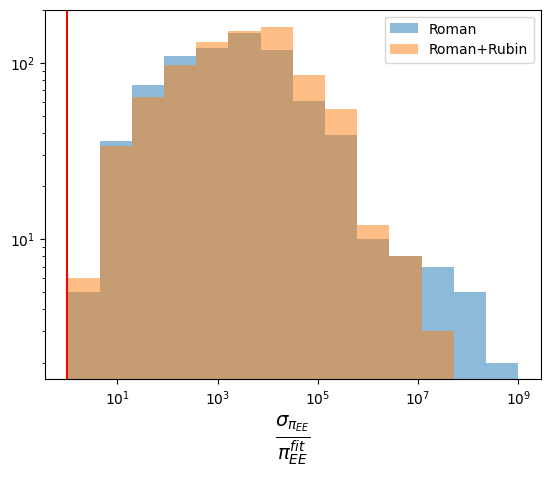

In [115]:
# print(len(met_3_roman['piEE']))
# print(len(met_3_roman['piEN']))

plt.hist(met_3_rr['piEN'],bins=np.logspace(0,9,15),alpha=0.5,label='Roman')
plt.hist(met_3_roman['piEN'],bins=np.logspace(0,9,15),alpha=0.5,label='Roman+Rubin')
plt.axvline(1,color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\frac{\sigma_{\pi_{EN}}}{\pi_{EN}^{fit}}$',fontsize=20)
plt.legend(loc='best')
plt.show()

plt.hist(met_3_rr['piEE'],bins=np.logspace(0,9,15),alpha=0.5,label='Roman')
plt.hist(met_3_roman['piEE'],bins=np.logspace(0,9,15),alpha=0.5,label='Roman+Rubin')
plt.axvline(1,color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\frac{\sigma_{\pi_{EE}}}{\pi_{EE}^{fit}}$',fontsize=20)
plt.legend(loc='best')
plt.show()

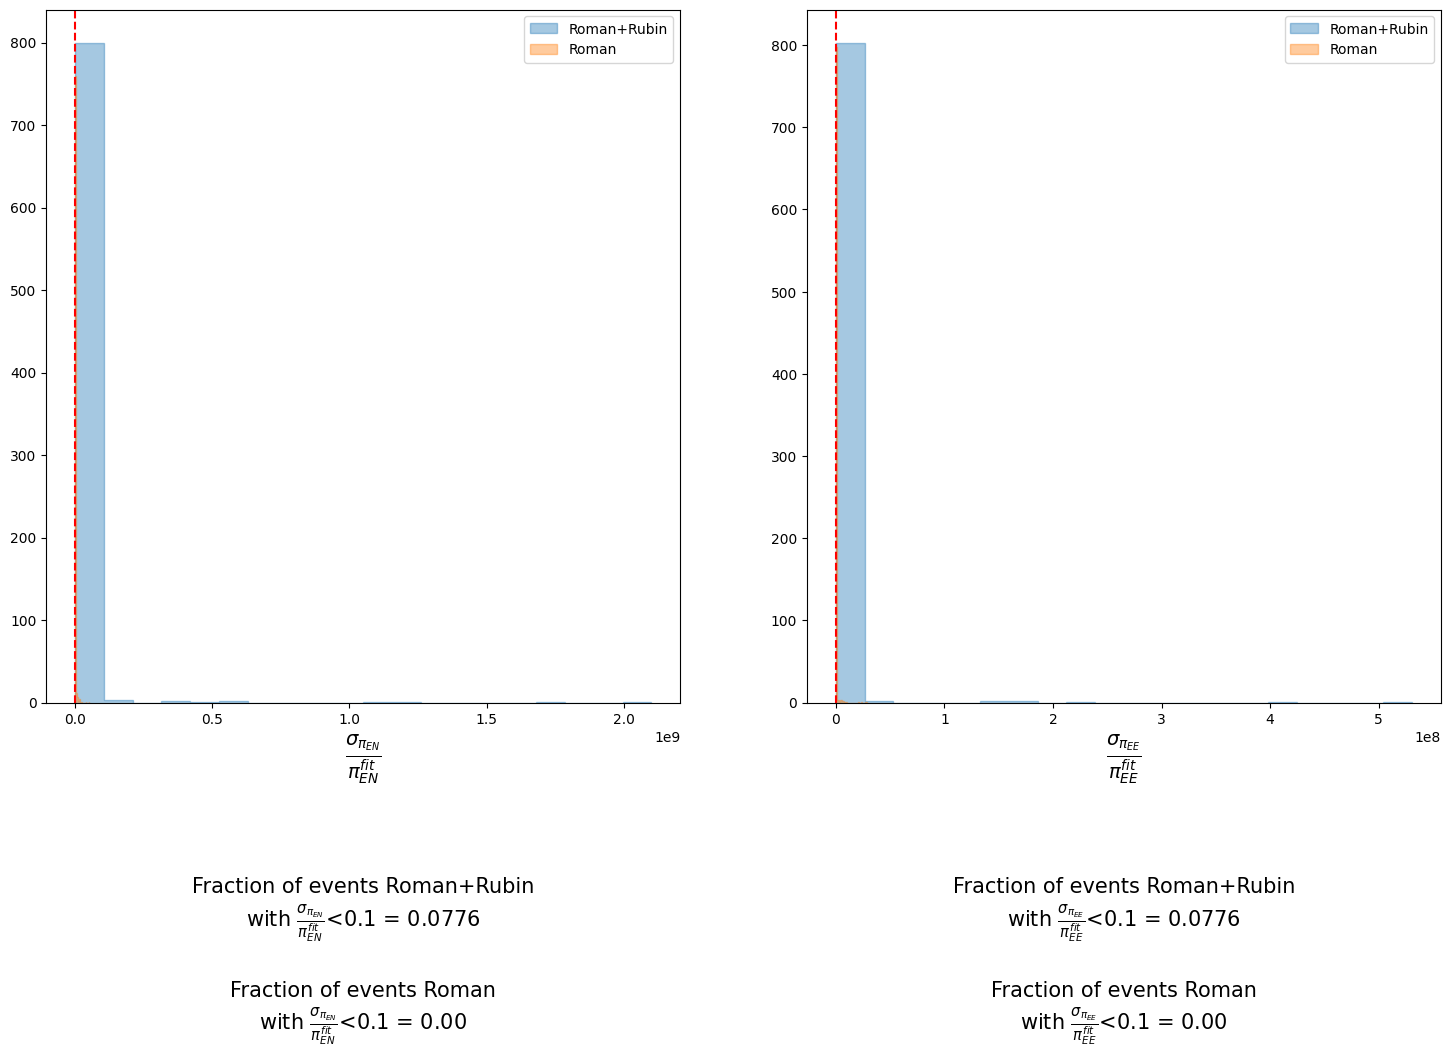

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

r1 = 'piEN'
plot_histogram(axes[0], met_3_rr[r1], met_3_roman[r1], r'$\frac{\sigma_{\pi_{EN}}}{\pi_{EN}^{fit}}$', f'$\pi_E$', 20,20)#np.arange(0,1000,1),np.arange(0,1000,1))

r2 = 'piEE'
plot_histogram(axes[1], met_3_rr[r2], met_3_roman[r2], r'$\frac{\sigma_{\pi_{EE}}}{\pi_{EE}^{fit}}$', f'$\pi_E$', 20,20)#np.arange(0,1000,1),np.arange(0,1000,1))

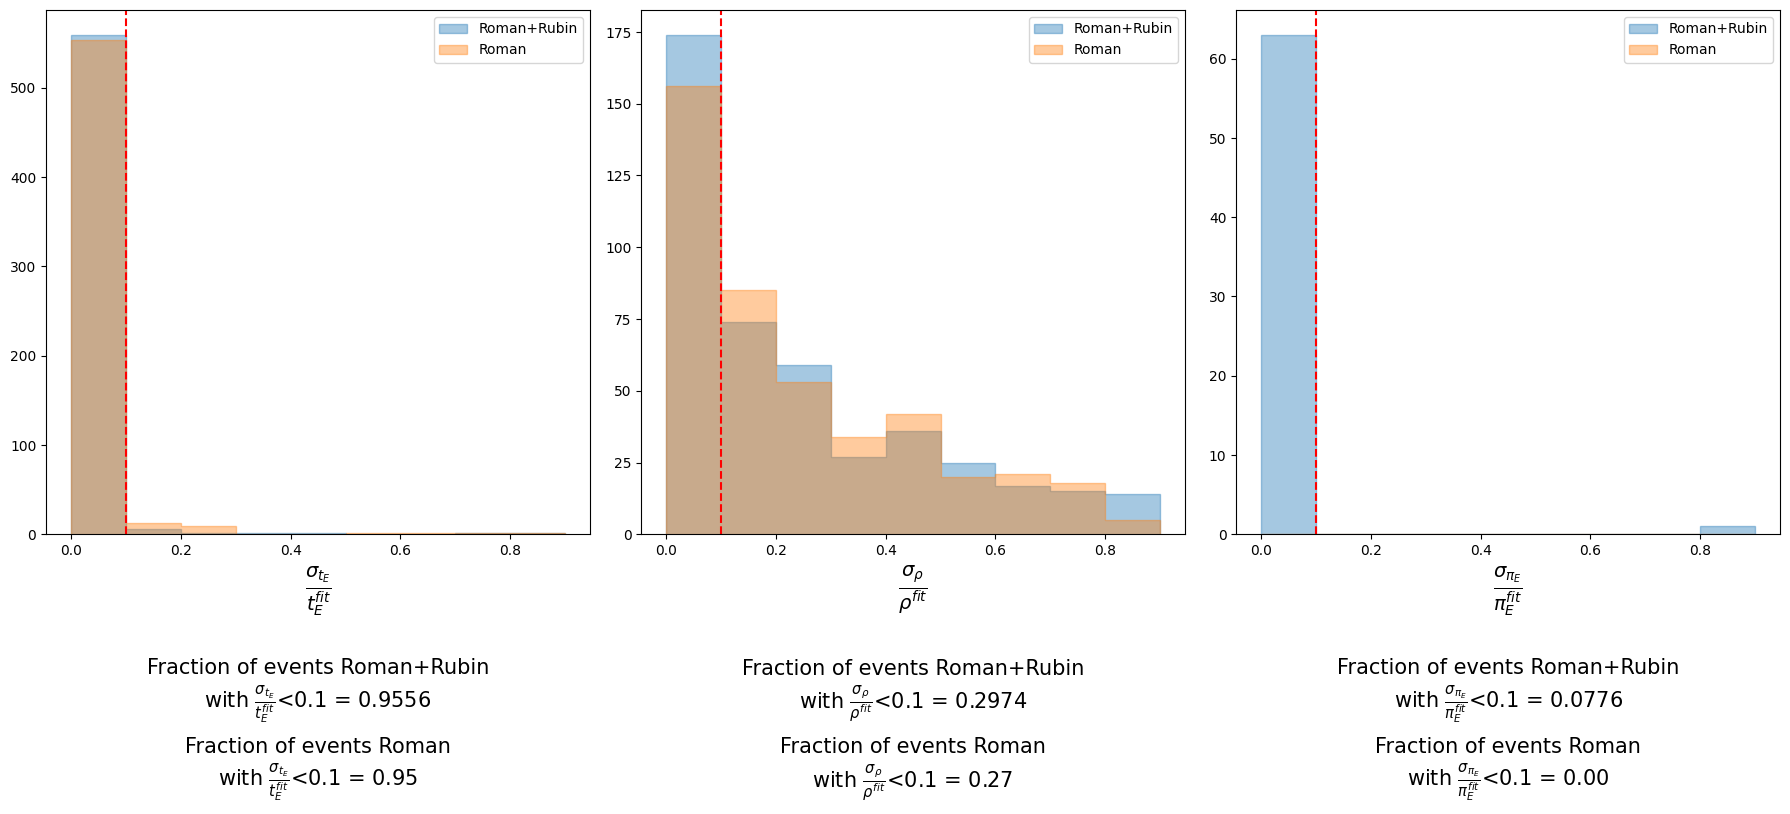

In [117]:
fig, axes = plt.subplots(1, 3, figsize=(18, 9))

cat = 'A'
mask = met_3_rr['Source'].isin(true['Source'][true['categories']==cat])
# Plot for 'te'
p = 'te'
plot_histogram(axes[0], met_3_rr[p][mask], met_3_roman[p][mask], label_m3(p), f'${labels[p]}$', bins1,bins2)
p = 'rho'
plot_histogram(axes[1], met_3_rr[p][mask], met_3_roman[p][mask], label_m3(p), f'${labels[p]}$', bins1,bins2)

r = 'piE'
plot_histogram(axes[2], met_3_rr[r], met_3_roman[r], r'$\frac{\sigma_{\pi_E}}{\pi_E^{fit}}$', f'$\pi_E$', np.arange(0,1,0.1),np.arange(0,1,0.1))

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

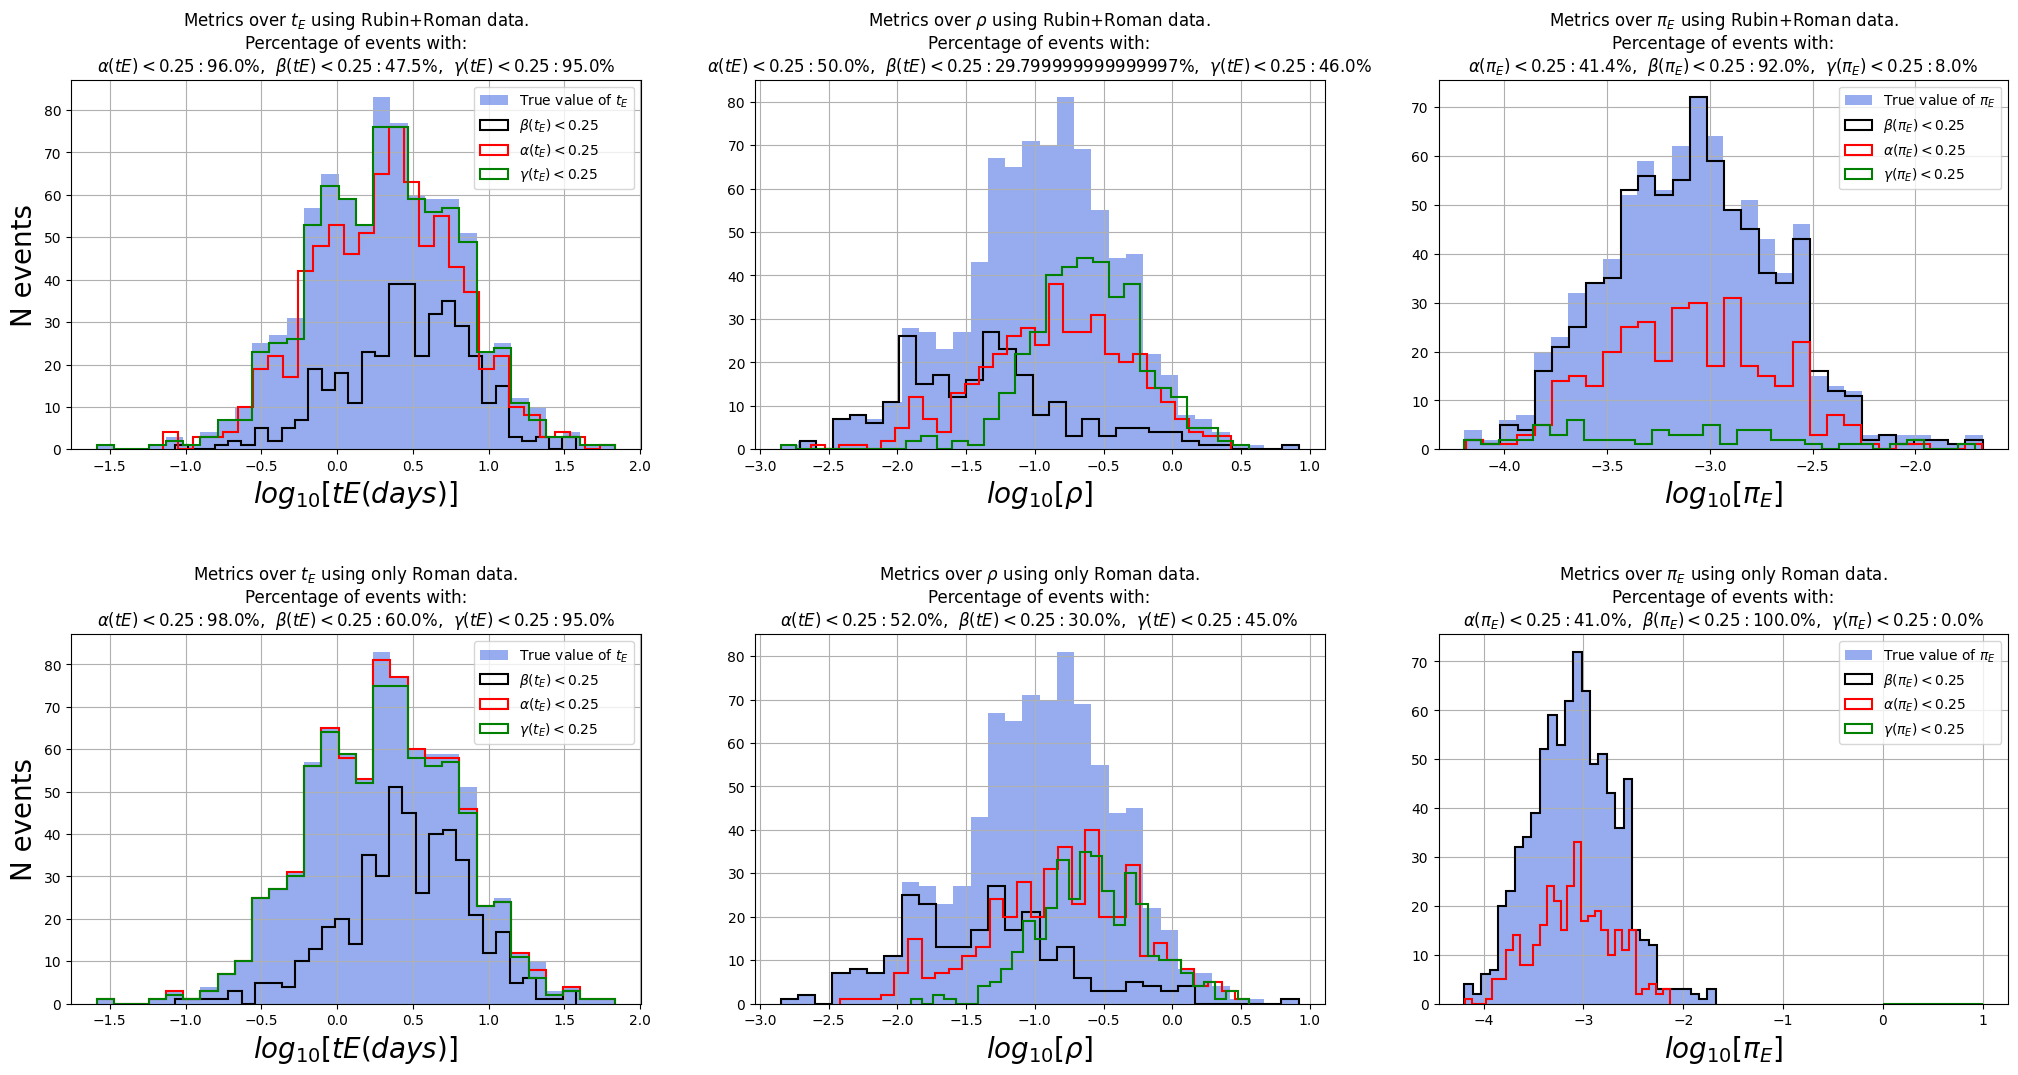

In [118]:
%matplotlib inline
plt.close('all')
# plt.figure(figsize=(8,6))
fig, axes = plt.subplots(2, 3, figsize=(25, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
axes[0,0].hist(np.log10(true['te']),bins=30,color='royalblue',alpha=0.55,label=r'True value of $t_E$')
axes[0,0].hist(np.log10(true['te'][true['Source'].isin(true['Source'][met_2_rr['te']<0.25])]),bins=30, histtype='step',color='k',lw=1.5,label=r'$\beta(t_E)<0.25$')
axes[0,0].hist(np.log10(true['te'][true['Source'].isin(true['Source'][met_1_rr['te']<0.25])]),bins=30, histtype='step',color='r',lw=1.5,label=r'$\alpha(t_E)<0.25$')
axes[0,0].hist(np.log10(true['te'][true['Source'].isin(true['Source'][met_3_rr['te']<0.25])]),bins=30, histtype='step',color='g',lw=1.5,label=r'$\gamma(t_E)<0.25$')
# plt.axvline(68.2,color='red')
# plt.yscale('log')
axes[0,0].set_xlabel(r'$log_{10}[tE(days)]$',fontsize=20)
axes[0,0].set_ylabel('N events',fontsize=20)
axes[0,0].grid(True)

axes[0,1].hist(np.log10(true['rho']),bins=30,color='royalblue',alpha=0.55,label=r'True value of $t_E$')
axes[0,1].hist(np.log10(true['rho'][true['Source'].isin(true['Source'][met_2_rr['rho']<0.25])]),bins=30, histtype='step',color='k',lw=1.5,label=r'$\beta(t_E)<0.25$')
axes[0,1].hist(np.log10(true['rho'][true['Source'].isin(true['Source'][met_1_rr['rho']<0.25])]),bins=30, histtype='step',color='r',lw=1.5,label=r'$\alpha(t_E)<0.25$')
axes[0,1].hist(np.log10(true['rho'][true['Source'].isin(true['Source'][met_3_rr['rho']<0.25])]),bins=30, histtype='step',color='g',lw=1.5,label=r'$\gamma(t_E)<0.25$')
# plt.axvline(68.2,color='red')
# plt.yscale('log')
axes[0,1].set_xlabel(r'$log_{10}[\rho]$',fontsize=20)
axes[1,0].set_ylabel('N events',fontsize=20)
axes[0,1].grid(True)
# plt.show()
# plt.close('all')
# plt.figure(figsize=(8,6))
axes[0,2].hist(np.log10(true['piE']),bins=30,color='royalblue',alpha=0.55,label=r'True value of $\pi_E$')
axes[0,2].hist(np.log10(true['piE'][true['Source'].isin(true['Source'][met_2_rr['piE']<0.25])]),bins=30, histtype='step',color='k',lw=1.5,label=r'$\beta(\pi_E)<0.25$')
axes[0,2].hist(np.log10(true['piE'][true['Source'].isin(true['Source'][met_1_rr['piE']<0.25])]),bins=30, histtype='step',color='r',lw=1.5,label=r'$\alpha(\pi_E)<0.25$')
axes[0,2].hist(np.log10(true['piE'][true['Source'].isin(true['Source'][met_3_rr['piE']<0.25])]),bins=30, histtype='step',color='g',lw=1.5,label=r'$\gamma(\pi_E)<0.25$')
# plt.axvline(68.2,color='red')
# plt.yscale('log')
axes[0,2].set_xlabel(r'$log_{10}[\pi_E]$',fontsize=20)
# axes[1].set_ylabel('N events',fontsize=20)
axes[0,2].grid(True)
axes[0,2].legend(loc='best')
axes[0,0].legend(loc='best')
# plt.suptitle('Roman and Rubin lightcurves',fontsize=18)
# plt.show()
# 
# plt.close('all')
# plt.figure(figsize=(8,6))
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[1,0].hist(np.log10(true['te']),bins=30,color='royalblue',alpha=0.55,label=r'True value of $t_E$')
axes[1,0].hist(np.log10(true['te'][true['Source'].isin(true['Source'][met_2_roman['te']<0.25])]),bins=30, histtype='step',color='k',lw=1.5,label=r'$\beta(t_E)<0.25$')
axes[1,0].hist(np.log10(true['te'][true['Source'].isin(true['Source'][met_1_roman['te']<0.25])]),bins=30, histtype='step',color='r',lw=1.5,label=r'$\alpha(t_E)<0.25$')
axes[1,0].hist(np.log10(true['te'][true['Source'].isin(true['Source'][met_3_roman['te']<0.25])]),bins=30, histtype='step',color='g',lw=1.5,label=r'$\gamma(t_E)<0.25$')
# plt.axvline(68.2,color='red')
# plt.yscale('log')
axes[1,0].set_xlabel(r'$log_{10}[tE(days)]$',fontsize=20)
# axes[1,0].set_ylabel('N events',fontsize=20)
axes[1,0].grid(True)


axes[1,1].hist(np.log10(true['rho']),bins=30,color='royalblue',alpha=0.55,label=r'True value of $t_E$')
axes[1,1].hist(np.log10(true['rho'][true['Source'].isin(true['Source'][met_2_roman['rho']<0.25])]),bins=30, histtype='step',color='k',lw=1.5,label=r'$\beta(t_E)<0.25$')
axes[1,1].hist(np.log10(true['rho'][true['Source'].isin(true['Source'][met_1_roman['rho']<0.25])]),bins=30, histtype='step',color='r',lw=1.5,label=r'$\alpha(t_E)<0.25$')
axes[1,1].hist(np.log10(true['rho'][true['Source'].isin(true['Source'][met_3_roman['rho']<0.25])]),bins=30, histtype='step',color='g',lw=1.5,label=r'$\gamma(t_E)<0.25$')
# plt.axvline(68.2,color='red')
# plt.yscale('log')
axes[1,1].set_xlabel(r'$log_{10}[\rho]$',fontsize=20)
# axes[1,1].set_ylabel('N events',fontsize=20)
axes[1,1].grid(True)
# plt.show()
# plt.close('all')
# plt.figure(figsize=(8,6))
axes[1,2].hist(np.log10(true['piE']),bins=30,color='royalblue',alpha=0.55,label=r'True value of $\pi_E$')
axes[1,2].hist(np.log10(true['piE'][true['Source'].isin(true['Source'][met_2_roman['piE']<0.25])]),bins=30, histtype='step',color='k',lw=1.5,label=r'$\beta(\pi_E)<0.25$')
axes[1,2].hist(np.log10(true['piE'][true['Source'].isin(true['Source'][met_1_roman['piE']<0.25])]),bins=30, histtype='step',color='r',lw=1.5,label=r'$\alpha(\pi_E)<0.25$')
axes[1,2].hist(np.log10(true['piE'][true['Source'].isin(true['Source'][met_3_roman['piE']<0.25])]),bins=30, histtype='step',color='g',lw=1.5,label=r'$\gamma(\pi_E)<0.25$')
# plt.axvline(68.2,color='red')
# plt.yscale('log')
axes[1,2].set_xlabel(r'$log_{10}[\pi_E]$',fontsize=20)
# axes[1].set_ylabel('N events',fontsize=20)
axes[1,2].grid(True)
axes[1,2].legend(loc='best')
axes[1,0].legend(loc='best')
# plt.suptitle('Roman lightcurves',fontsize=18)
axes[1,0].set_title(r'Metrics over $t_E$ using only Roman data.'+'\nPercentage of events with:\n'+r"$\alpha(tE)<0.25:$"+f"{100*round(len(met_1_roman['te'][met_1_roman['te']<0.25])/len(true),2)}%"+r',  $\beta(tE)<0.25:$'+f"{100*round(len(met_2_roman['te'][met_2_roman['te']<0.25])/len(true),1)}%"+r',  $\gamma(tE)<0.25:$'+f"{100*round(len(met_3_roman['te'][met_3_roman['te']<0.25])/len(true),2)}%")
axes[1,2].set_title(r'Metrics over $\pi_E$ using only Roman data.'+'\nPercentage of events with:\n'+r"$\alpha(\pi_E)<0.25:$"+f"{100*round(len(met_1_roman['piE'][met_1_roman['piE']<0.25])/len(true),2)}%"+r',  $\beta(\pi_E)<0.25:$'+f"{100*round(len(met_2_roman['piE'][met_2_roman['piE']<0.25])/len(true),2)}%"+r',  $\gamma(\pi_E)<0.25:$'+f"{100*round(len(met_3_roman['piE'][met_3_roman['piE']<0.25])/len(true),2)}%")

axes[0,0].set_title(r'Metrics over $t_E$ using Rubin+Roman data.'+'\nPercentage of events with:\n'+r"$\alpha(tE)<0.25:$"+f"{100*round(len(met_1_rr['te'][met_1_rr['te']<0.25])/len(true),2)}%"+r',  $\beta(tE)<0.25:$'+f"{100*round(len(met_2_rr['te'][met_2_rr['te']<0.25])/len(true),3)}%"+r',  $\gamma(tE)<0.25:$'+f"{100*round(len(met_3_rr['te'][met_3_rr['te']<0.25])/len(true),2)}%")
axes[0,2].set_title(r'Metrics over $\pi_E$ using Rubin+Roman data.'+'\nPercentage of events with:\n'+r"$\alpha(\pi_E)<0.25:$"+f"{100*round(len(met_1_rr['piE'][met_1_rr['piE']<0.25])/len(true),3)}%"+r',  $\beta(\pi_E)<0.25:$'+f"{100*round(len(met_2_rr['piE'][met_2_rr['piE']<0.25])/len(true),2)}%"+r',  $\gamma(\pi_E)<0.25:$'+f"{100*round(len(met_3_rr['piE'][met_3_rr['piE']<0.25])/len(true),2)}%")


axes[1,1].set_title(r'Metrics over $\rho$ using only Roman data.'+'\nPercentage of events with:\n'+r"$\alpha(tE)<0.25:$"+f"{100*round(len(met_1_roman['rho'][met_1_roman['rho']<0.25])/len(true),2)}%"+r',  $\beta(tE)<0.25:$'+f"{100*round(len(met_2_roman['rho'][met_2_roman['rho']<0.25])/len(true),1)}%"+r',  $\gamma(tE)<0.25:$'+f"{100*round(len(met_3_roman['rho'][met_3_roman['rho']<0.25])/len(true),2)}%")
axes[0,1].set_title(r'Metrics over $\rho$ using Rubin+Roman data.'+'\nPercentage of events with:\n'+r"$\alpha(tE)<0.25:$"+f"{100*round(len(met_1_rr['rho'][met_1_rr['rho']<0.25])/len(true),2)}%"+r',  $\beta(tE)<0.25:$'+f"{100*round(len(met_2_rr['rho'][met_2_rr['rho']<0.25])/len(true),3)}%"+r',  $\gamma(tE)<0.25:$'+f"{100*round(len(met_3_rr['rho'][met_3_rr['rho']<0.25])/len(true),2)}%")

plt.show()

In [76]:
true[(true["categories"]=='A')&(true["te"]>5)]

,Source,t0,u0,te,rho,piEN,piEE,categories,piE
9,7085,2.461525e+06,0.815573,5.646070,0.010738,0.001958,-0.000396,A,0.001997
18,9194,2.462977e+06,0.758764,6.287754,0.055572,0.000520,0.000086,A,0.000527
22,7155,2.462941e+06,0.113492,6.082465,0.012948,0.000740,-0.000947,A,0.001202
30,9254,2.461656e+06,0.376773,9.454427,0.032922,0.000105,-0.000976,A,0.000982
31,9257,2.462743e+06,0.490939,5.056717,0.022286,0.003259,0.000099,A,0.003261
...,...,...,...,...,...,...,...,...,...
773,23039,2.461686e+06,0.419598,9.904001,0.330212,0.001453,0.000667,A,0.001599
790,23489,2.462572e+06,0.793323,6.809821,0.149456,0.000396,-0.000707,A,0.000810
793,21565,2.461881e+06,0.900442,7.080047,0.096519,0.001220,-0.000079,A,0.001223
799,21671,2.462601e+06,0.363564,8.399025,0.092952,0.002373,0.001405,A,0.002758


# mass estimation

$\theta_E\pi_E=\pi_{rel}$
$$M=\frac{\theta_E}{\kappa\pi_{E}}=\frac{\theta_E}{\kappa\sqrt{\pi_{EE}^2+\pi_{EN}^2}} $$

$$\frac{\partial M}{\partial \theta_E}=\frac{1}{\kappa\sqrt{\pi_{EE}^2+\pi_{EN}^2}}=\frac{1}{\kappa\pi_{E}} $$
$$\frac{\partial M}{\partial \pi_{EE}}=-\frac{\theta_E \pi_{EE}}{\kappa[\pi_{EE}^2+\pi_{EN}^2]^{3/2}}=-\frac{\theta_E \pi_{EE}}{\kappa\pi_{E}^{3}} $$
$$\frac{\partial M}{\partial \pi_{EN}}=-\frac{\theta_E\pi_{EN}}{\kappa[\pi_{EE}^2+\pi_{EN}^2]^{3/2}} =-\frac{\theta_E \pi_{EN}}{\kappa\pi_{E}^{3}}$$


$$\sigma_M^2 = \left(\frac{\partial M}{\partial \theta_E} \sigma_{\theta_{E}}\right)^2 + \left(\frac{\partial M}{\partial \pi_{EE}} \sigma_{\pi_{EE}}\right)^2+ \left(\frac{\partial M}{\partial \pi_{EN}} \sigma_{\pi_{EN}}\right)^2 + 2\frac{\partial M}{\partial \pi_{EE}}\frac{\partial M}{\partial \pi_{EN}} cov(\pi_{EN},\pi_{EE})+ \frac{\partial M}{\partial \pi_{EE}}\frac{\partial M}{\partial \theta_E}cov(\pi_{EE},\theta_{E})+ \frac{\partial M}{\partial \pi_{EN}}\frac{\partial M}{\partial \theta_E}cov(\pi_{EN},\theta_{E})$$
if we consider $cov(\theta_E,\pi_{EE})=0$ , $cov(\theta_E,\pi_{EN})=0$
$$\sigma_M^2 = \left(\frac{\partial M}{\partial \theta_E} \sigma_{\theta_{E}}\right)^2 + \left(\frac{\partial M}{\partial \pi_{EE}} \sigma_{\pi_{EE}}\right)^2+ \left(\frac{\partial M}{\partial \pi_{EN}} \sigma_{\pi_{EN}}\right)^2 + 2\frac{\partial M}{\partial \pi_{EE}}\frac{\partial M}{\partial \pi_{EN}} cov(\pi_{EN},\pi_{EE})$$

$$\sigma_M^2 = \left(\frac{\theta_E}{\kappa\pi_{E}} 0.1\right)^2 + \left(\frac{\theta_E \pi_{EE}}{\kappa\pi_{E}^{3}} \sigma_{\pi_{EE}}\right)^2+ \left(\frac{\theta_E \pi_{EN}}{\kappa\pi_{E}^{3}} \sigma_{\pi_{EN}}\right)^2 + 2\frac{\theta_E \pi_{EE}}{\kappa\pi_{E}^{3}}\frac{\theta_E \pi_{EN}}{\kappa\pi_{E}^{3}} cov(\pi_{EN},\pi_{EE})$$

$$\sigma_M^2 = M^2\left[\left( 0.1\right)^2 + \left(\frac{ \pi_{EE}}{\pi_{E}^{2}} \sigma_{\pi_{EE}}\right)^2+ \left(\frac{ \pi_{EN}}{\pi_{E}^{2}} \sigma_{\pi_{EN}}\right)^2 + 2\frac{ \pi_{EE}}{\pi_{E}^{2}}\frac{ \pi_{EN}}{\pi_{E}^{2}} cov(\pi_{EN},\pi_{EE})\right]$$

$$\sigma_M = M\sqrt{\left[\left( 0.1\right)^2 + \left(\frac{ \pi_{EE}}{\pi_{E}^{2}} \sigma_{\pi_{EE}}\right)^2+ \left(\frac{ \pi_{EN}}{\pi_{E}^{2}} \sigma_{\pi_{EN}}\right)^2 + 2\frac{ \pi_{EE}}{\pi_{E}^{2}}\frac{ \pi_{EN}}{\pi_{E}^{2}} cov(\pi_{EN},\pi_{EE})\right]}$$


In [59]:
len(met_3_rr[met_3_rr['piEE']>1])

746

In [60]:
# print(true[true['te']>4])

print(len(met_3_rr[met_3_rr['piEE']>1])/len(met_3_rr[met_3_rr['piEE']>1]))

1.0


In [119]:
# Define constants
aconv = (180 * 60 * 60 * 1000) / math.pi
c = const.c
G = const.G
k = 4 * G / (c ** 2)
# Initialize lists to store results
err_rel_M = []
M_fit_list_rr = []
M_fit_list_roman = []
M_true_list = []
error_m_rr = []
error_m_roman = []

def calculate_mass_and_error(fit_params, thetaE):
    piE_fit = fit_params['piE'].values[0] * (1 / u.kpc)
    
    piEE_fit = fit_params['piEE'].values[0] * (1 / u.kpc)
    piEN_fit = fit_params['piEN'].values[0] * (1 / u.kpc)

    sigma_piee = fit_params['piEE_err'].values[0] * (1 / u.kpc)
    sigma_pien = fit_params['piEN_err'].values[0] * (1 / u.kpc)

    # Calculate the fitted mass
    M_fit = ((thetaE / aconv**2) / (k * piE_fit)).decompose().to('M_sun')
    # Derivatives for error propagation
    dm_dpiee = ((thetaE * (-piEE_fit) / aconv**2) / (k * piE_fit**3)).decompose()
    dm_dpien = ((thetaE * (-piEN_fit) / aconv**2) / (k * piE_fit**3)).decompose()
    dm_dthetaE = ((1  / aconv**2) / (k * piE_fit)).decompose()
    # Quadratic terms for the error
    cuad_terms =  (dm_dpiee * sigma_piee)**2 + (dm_dpien * sigma_pien)**2 + (dm_dthetaE * 0.1 * thetaE)**2
    # Covariance terms for the error
    cov_terms = 2*dm_dpiee * dm_dpien * fit_params['cov_piEE_piEN'].values[0] * (1 / u.kpc)**2
    # print(cuad_terms, cov_terms)
    # Total error in mass
    sigma_m = cuad_terms + cov_terms
    # print(np.sqrt(sigma_m).to('M_sun').value/M_fit.value)
    # print(M_fit.value, np.sqrt(sigma_m).to('M_sun').value)
    return M_fit.value, np.sqrt(sigma_m).to('M_sun').value

# Loop through each event in met_3_rr

for i in tqdm(range(len(met_3_rr.values))):
    event_good_metric = met_3_rr['Source'].iloc[i]
    # Determine the file and row index for the event
    nset = int(event_good_metric / 5000)
    # print(nset)
    nsource = int(event_good_metric - nset * 5000)
    # Read the TRILEGAL parameters for the event
    trilegal_params = pd.read_csv(f'/home/anibal/results_roman_rubin/FFP_uni_split_{nset}.csv').iloc[nsource]
    # Extract necessary parameters
    Rstar = trilegal_params['radius'] * u.R_sun
    DS = trilegal_params['D_S'] * u.pc
    DL = trilegal_params['D_L'] * u.pc
    pi_rel = ((1 / DL) - (1 / DS))
    theta_s = np.arctan(Rstar / DS).decompose().to('mas').value
    thetaE = theta_s / trilegal_params['rho']
    piEE = trilegal_params['piEE']
    piEN = trilegal_params['piEN']
    piE = np.sqrt(piEE**2 + piEN**2) * (1 / u.kpc)
    # Calculate the true mass
    M_true = ((thetaE / aconv**2) / (k * piE)).decompose().to('M_sun')
    # Append true mass to the list
    M_true_list.append(M_true.value)
    
    # Calculate mass and error for Rubin
    M_fit_rr, sigma_m_rr = calculate_mass_and_error(fit_rr[fit_rr['Source']==event_good_metric], thetaE)
    M_fit_list_rr.append(M_fit_rr)
    error_m_rr.append(sigma_m_rr)
    
    # Calculate mass and error for Roman
    M_fit_roman, sigma_m_roman = calculate_mass_and_error(fit_roman[fit_roman['Source']==event_good_metric], thetaE)
    M_fit_list_roman.append(M_fit_roman)
    error_m_roman.append(sigma_m_roman)

  0%|          | 0/812 [00:00<?, ?it/s]

/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

para hallar la masa del planeta usamos $q=\frac{M_p}{M_s}$ y la masa total que derivamos aca $M_T=M_p+M_s$ $$M_p =\frac{ M_T q}{q+1}$$

In [ ]:
# 933-415

In [ ]:
err_rel_roman = np.array(error_m_roman)/ np.array(M_fit_list_roman)
err_rel_rr = np.array(error_m_rr)/ np.array(M_fit_list_rr)
# print(min(err_rel_roman),min(err_rel_rr))
plt.hist(err_rel_roman,bins=20,label='Roman:'+f'{len(err_rel_roman[err_rel_roman<0.25])/len(err_rel_roman)}')
plt.hist(err_rel_rr,bins=20,label='RR:'+f'{len(err_rel_rr[err_rel_rr<0.25])/len(err_rel_rr)}')

plt.xlabel(r'$\frac{\sigma_M}{M_fit}$')
# plt.ylabel(r'$M_{fit}$')
plt.legend(loc='best')

In [ ]:
plot_histogram

In [ ]:
# Define labels
label_mass_m3 = r'$\frac{\sigma_{M}}{M^{fit}}$'
label_mass_m2 = r'$\frac{|M^{true}-M^{fit}|}{\sigma_{M}}$'
label_mass_m1 = r'$\frac{|M^{true}-M^{fit}|}{M^{true}}$'

# Function to plot histograms
# def plot_histogram(ax, data_roman, data_rr, min_bin, max_bin, bin_count, xlabel, label_position, label_fraction):
#     bins = np.linspace(min_bin, max_bin, bin_count)
#     ax.hist(data_rr, bins=bins, fill=True, alpha=0.4, histtype='step', label='Roman+Rubin')
#     ax.hist(data_roman, bins=bins, fill=True, alpha=0.4, histtype='step', label='Roman')
#     ax.set_xlabel(xlabel, fontsize=20)
#     ax.axvline(0.25, color='red', linestyle='--')
#     ax.legend(loc='best')
#     ax.annotate(f'Fraction of events\n Roman+Rubin with {xlabel}<0.2 = {len(data_rr[data_rr < 0.25]) / len(data_rr):.3f}', 
#                 xy=(0.5, label_position), xycoords='axes fraction',
#                 ha='center', va='center', fontsize=12)
#     ax.annotate(f'Fraction of events\n Roman with {xlabel}<0.2 = {len(data_roman[data_roman < 0.25]) / len(data_roman):.3f}', 
#                 xy=(0.5, label_position-0.15), xycoords='axes fraction',
#                 ha='center', va='center', fontsize=12)

# Generate data for plotting
mass_m3_roman = np.array(error_m_roman) / np.abs(np.array(M_fit_list_roman))
mass_m3_rr = np.array(error_m_rr) / np.abs(np.array(M_fit_list_rr))
mass_m2_roman = np.abs(np.array(M_true_list) - np.array(M_fit_list_roman)) / np.array(error_m_roman)
mass_m2_rr = np.abs(np.array(M_true_list) - np.array(M_fit_list_rr)) / np.array(error_m_rr)
mass_m1_roman = np.abs(np.array(M_true_list) - np.array(M_fit_list_roman)) / np.array(M_true_list)
mass_m1_rr = np.abs(np.array(M_true_list) - np.array(M_fit_list_rr)) / np.array(M_true_list)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 9))

# # Plot histograms
plot_histogram(axes[0], mass_m3_roman, mass_m3_rr, 0, 1, 20, label_mass_m3)
plot_histogram(axes[1], mass_m2_roman, mass_m2_rr, 0, 5, 20, label_mass_m2)
plot_histogram(axes[2], mass_m1_roman, mass_m1_rr, 0, 1.25, 20, label_mass_m1)

# # Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# plt.hist(mass_m3_rr)
# plt.hist(mass_m3_roman)

In [ ]:
# len(true[true['rho']>0.01])/len(true)